# Breast Cancer Histology: Full Pipeline with Advanced Segmentation

This notebook implements the complete workflow using an SVM classifier and an advanced nuclei segmentation strategy:

1. Finds all relevant image paths and extracts patient/slide IDs based on the specified magnification.
2. Splits patient/slide IDs into Training and Testing sets (patient-level split).
3. Extracts features ONLY from the Training image set using advanced segmentation tuned for the specified magnification.
4. Cleans, preprocesses (scaling), and trains multiple machine learning models on the Training features.
5. Extracts features ONLY from the Testing image set using the same advanced segmentation parameters.
6. Cleans and preprocesses (using the scaler and imputer fitted on Training data) the Testing features.
7. Evaluates the trained models on the unseen Testing features.

**Advanced Segmentation Strategy (Tunable Per Magnification):**

- Color Deconvolution (Hematoxylin channel isolation)
- Adaptive Thresholding (Otsu) or Manual Thresholding
- Morphological Operations (Opening, Closing)
- Watershed Segmentation (Optional, for separating nuclei)
- Contour Filtering (Area, Circularity, per magnification)


## 1. Imports


In [25]:
import cv2
import numpy as np
import pandas as pd
import os
import math
import pathlib
import json # For potentially loading/displaying config

from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Scikit-image for advanced segmentation
from skimage import color, exposure
# from scipy import ndimage # Not strictly needed if cv2.connectedComponents is used

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb # Import XGBoost
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support
)
from sklearn.exceptions import NotFittedError

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Configuration


In [26]:
# --- Path to Dataset ---
notebook_launch_dir = pathlib.Path.cwd()
# Assuming this notebook is in 'breast_cancer_histology_analysis/notebooks/'
# And 'raw' data is in 'breast_cancer_histology_analysis/data/raw/'
PROJ_ROOT_DIR = notebook_launch_dir # This should be 'breast_cancer_histology_analysis' root
ROOT_DATA_DIR = PROJ_ROOT_DIR /  'raw'
CONFIG_FILE_PATH = PROJ_ROOT_DIR / 'config' / 'segmentation_config.json'

# --- Magnification to Process in this Run --- 
# USER ACTION: Change this to '40X', '100X', '200X', or '400X' for each specific run
TARGET_MAGNIFICATION = '200X' 
print(f"INFO: Processing for Magnification: {TARGET_MAGNIFICATION}")

# --- Modeling Parameters ---
TEST_SET_SIZE = 0.10  # Proportion of unique patient/slide IDs for the test set
RANDOM_STATE = 42
NAN_HANDLING_STRATEGY = 'drop'  # 'drop' or 'impute_mean'

# --- Feature Names ---
FEATURE_NAMES_BASE = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
                      'compactness', 'concavity', 'concave_points', 'symmetry',
                      'fractal_dimension']
FEATURE_COLUMNS = [f'{name}{suffix}' for name in FEATURE_NAMES_BASE for suffix in [
    '_mean', '_se', '_max']]

# --- Load Tuned Segmentation Configuration from JSON file ---
try:
    with open(CONFIG_FILE_PATH, 'r') as f:
        SEGMENTATION_CONFIG = json.load(f)
    print(f"Successfully loaded segmentation config from {CONFIG_FILE_PATH}")
    # print("Using SEGMENTATION_CONFIG:", json.dumps(SEGMENTATION_CONFIG, indent=2))
except FileNotFoundError:
    print(f"ERROR: {CONFIG_FILE_PATH} not found. Please ensure you have saved your tuned config from segmentation_tuner.py")
    # Fallback to a default if needed, or raise an error
    SEGMENTATION_CONFIG = {} # Or raise Exception("Config file missing")
except json.JSONDecodeError:
    print(f"ERROR: Could not decode JSON from {CONFIG_FILE_PATH}. Please check its format.")
    SEGMENTATION_CONFIG = {}

if not SEGMENTATION_CONFIG or TARGET_MAGNIFICATION not in SEGMENTATION_CONFIG.get('contour_filters_by_magnification', {}):
    print(f"ERROR: TARGET_MAGNIFICATION '{TARGET_MAGNIFICATION}' not found in the loaded SEGMENTATION_CONFIG's contour_filters_by_magnification or config is empty.")
    # Handle error appropriately, e.g., by stopping execution or using a very basic default
    # For now, we'll let it potentially fail later if this config is critical and missing.


INFO: Processing for Magnification: 200X
Successfully loaded segmentation config from /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/config/segmentation_config.json


## 3. Helper Functions (Segmentation, Feature Calculation, Evaluation)


In [27]:
def get_hematoxylin_channel(image_rgb):
    """Extracts the Hematoxylin channel using scikit-image's color deconvolution."""
    image_rgb_safe = np.clip(image_rgb, 1, 255)
    try:
        ihc_hed = color.rgb2hed(image_rgb_safe)
        h_channel = ihc_hed[:, :, 0]
        h_channel_norm = cv2.normalize(h_channel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        return h_channel_norm
    except Exception as e:
        print(f"Warning: Color deconvolution failed: {e}. Returning grayscale image instead.")
        if len(image_rgb.shape) == 3:
            return cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        return image_rgb # Assume it's already grayscale if not 3 channels

def calculate_circularity(contour):
    """Calculates the circularity of a contour."""
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if perimeter == 0 or area == 0:
        return 0.0
    return (4 * np.pi * area) / (perimeter ** 2)

def segment_nuclei_pipeline(image_bgr, magnification, config):
    """Advanced nuclei segmentation for pipeline use. Returns only filtered contours."""
    if image_bgr is None: return []

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    h_channel = get_hematoxylin_channel(image_rgb)

    if h_channel is None: return [] # Failed to get H-channel

    h_channel_processed = h_channel.copy()

    if config.get('contrast_stretch', False):
        p_low = config.get('contrast_percentiles_low', 2)
        p_high = config.get('contrast_percentiles_high', 98)
        if 0 <= p_low < p_high <= 100:
            p_low_val, p_high_val = np.percentile(h_channel_processed, (p_low, p_high))
            if p_low_val < p_high_val:
                h_channel_processed = exposure.rescale_intensity(h_channel_processed, in_range=(p_low_val, p_high_val))
                h_channel_processed = cv2.normalize(h_channel_processed, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    if config.get('threshold_method') == 'otsu':
        _, binary_mask = cv2.threshold(h_channel_processed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        manual_thresh = config.get('manual_threshold_value', 100)
        _, binary_mask = cv2.threshold(h_channel_processed, manual_thresh, 255, cv2.THRESH_BINARY)

    open_k_size = config.get('morph_open_kernel_size', 3)
    if open_k_size % 2 == 0: open_k_size = max(1, open_k_size -1) # Ensure odd and positive
    close_k_size = config.get('morph_close_kernel_size', 3)
    if close_k_size % 2 == 0: close_k_size = max(1, close_k_size -1)
    
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k_size, open_k_size))
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_open, iterations=config.get('morph_open_iterations', 1))
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k_size, close_k_size))
    cleaned_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel_close, iterations=config.get('morph_close_iterations', 1))

    final_contours_list = []
    mag_filters_dict = config.get('contour_filters_by_magnification', {})
    mag_specific_filters = mag_filters_dict.get(magnification, mag_filters_dict.get('200X', {})) # Fallback
    if not mag_specific_filters: # Critical if no filters defined for the target magnification
        print(f"Warning: No specific contour filters for magnification {magnification} or fallback 200X. Using very basic defaults.")
        mag_specific_filters = {'min_area': 10, 'max_area': 100000, 'min_circularity': 0.01, 'dist_transform_thresh_ratio': 0.3}

    if config.get('use_watershed', False):
        sure_bg_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        sure_bg = cv2.dilate(cleaned_mask, sure_bg_kernel, iterations=3)
        dist_transform = cv2.distanceTransform(cleaned_mask, cv2.DIST_L2, 5)
        default_global_dt_ratio = config.get('dist_transform_thresh_ratio', 0.3)
        current_dist_thresh_ratio = mag_specific_filters.get('dist_transform_thresh_ratio', default_global_dt_ratio)
        _, sure_fg = cv2.threshold(dist_transform, current_dist_thresh_ratio * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        try:
            markers_copy = markers.copy()
            watershed_input_img = image_rgb.copy()
            cv2.watershed(watershed_input_img, markers_copy)
            unique_marker_values = np.unique(markers_copy)
            for marker_val in unique_marker_values:
                if marker_val <= 1: continue
                nucleus_mask_ws = np.zeros(cleaned_mask.shape, dtype=np.uint8)
                nucleus_mask_ws[markers_copy == marker_val] = 255
                contours_ws, _ = cv2.findContours(nucleus_mask_ws, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours_ws: final_contours_list.extend(contours_ws)
        except cv2.error as e:
            contours_fb, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            final_contours_list = contours_fb
    else: 
        contours_no_ws, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        final_contours_list = contours_no_ws

    min_area = mag_specific_filters.get('min_area', 0)
    max_area = mag_specific_filters.get('max_area', float('inf'))
    min_circ = mag_specific_filters.get('min_circularity', 0.0)
    
    filtered_contours = []
    for cnt in final_contours_list:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            circularity = calculate_circularity(cnt)
            if circularity >= min_circ:
                filtered_contours.append(cnt)
    return filtered_contours

def calculate_contour_features(contour, gray_image):
    """Calculates a dictionary of features for a single contour."""
    features = {}
    try:
        moments = cv2.moments(contour)
        area = cv2.contourArea(contour)
        if area <= 0: return None
        perimeter = cv2.arcLength(contour, True)
        equivalent_diameter = np.sqrt(4 * area / np.pi)
        features['radius'] = equivalent_diameter / 2.0
        mask = np.zeros(gray_image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, color=255, thickness=cv2.FILLED)
        mean_val, stddev_val = cv2.meanStdDev(gray_image, mask=mask)
        features['texture'] = stddev_val[0][0] if stddev_val is not None and stddev_val.size > 0 else 0.0
        features['perimeter'] = perimeter
        features['area'] = area
        if moments['m00'] > 0 and len(contour) > 1:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            center = np.array([cx, cy])
            contour_points = contour.reshape(-1, 2)
            distances = np.sqrt(np.sum((contour_points - center)**2, axis=1))
            features['smoothness'] = np.std(distances) if distances.size > 0 else 0.0
        else:
            features['smoothness'] = 0.0
        features['compactness'] = (perimeter ** 2) / area if area > 0 else 0.0
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        features['concavity'] = 1.0 - (area / hull_area) if hull_area > 0 else 0.0
        try:
            if len(contour) > 3:
                hull_indices = cv2.convexHull(contour, returnPoints=False)
                if hull_indices is not None and len(hull_indices) > 3:
                    defects = cv2.convexityDefects(contour, hull_indices)
                    concave_points_count = 0
                    if defects is not None:
                        min_defect_depth_ratio = 0.05
                        min_depth_pixels = min_defect_depth_ratio * equivalent_diameter
                        for i in range(defects.shape[0]):
                            s, e, f, d = defects[i, 0]
                            depth = d / 256.0
                            if depth > min_depth_pixels: concave_points_count += 1
                        features['concave_points'] = concave_points_count
                    else: features['concave_points'] = 0
                else: features['concave_points'] = 0
            else: features['concave_points'] = 0
        except cv2.error: features['concave_points'] = 0
        if len(contour) >= 5:
            try:
                (x, y), (ma, MA), angle = cv2.fitEllipse(contour)
                features['symmetry'] = ma / MA if MA > 0 else 1.0
            except cv2.error: features['symmetry'] = 0.0
        else: features['symmetry'] = 0.0
        features['fractal_dimension'] = perimeter / np.sqrt(area) if area > 0 else 0.0
        return features
    except Exception as e:
        return None

## 4. Gather Image Paths and Split Data (Patient-Level)

This section will focus only on the `TARGET_MAGNIFICATION`.

In [28]:
all_image_paths_info = []
print(f"Scanning directory: {ROOT_DATA_DIR} for {TARGET_MAGNIFICATION} images...")

for root, dirs, files in os.walk(ROOT_DATA_DIR):
    path_parts = list(pathlib.Path(root).parts)
    if len(path_parts) >= 7 and path_parts[-1] == TARGET_MAGNIFICATION and files:
        try:
            magnification = path_parts[-1]
            patient_slide_id = path_parts[-2]
            main_diagnosis_folder = path_parts[-5]

            if main_diagnosis_folder.lower() not in ['benign', 'malignant']:
                continue
            diagnosis_label = 'M' if main_diagnosis_folder.lower() == 'malignant' else 'B'

            if magnification not in SEGMENTATION_CONFIG.get('contour_filters_by_magnification', {}):
                print(f"Warning: TARGET_MAGNIFICATION {magnification} not in SEGMENTATION_CONFIG keys. This might lead to issues.")
                # Depending on strictness, you might want to 'continue' or raise error

            for file_name in files:
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    all_image_paths_info.append({
                        'path': os.path.join(root, file_name),
                        'filename': file_name,
                        'diagnosis': diagnosis_label,
                        'magnification': magnification,
                        'patient_slide_id': patient_slide_id
                    })
        except IndexError:
            continue
        except Exception as e:
            print(f"Error parsing path info for {root}: {e}")

print(
    f"Found {len(all_image_paths_info)} total {TARGET_MAGNIFICATION} images from {len(set(item['patient_slide_id'] for item in all_image_paths_info))} unique patient/slides.")

train_image_info_list, test_image_info_list = [], []
df_all_images = pd.DataFrame()

if not all_image_paths_info:
    print(f"CRITICAL ERROR: No {TARGET_MAGNIFICATION} images found. Pipeline cannot continue.")
    # Potentially raise an error or exit if this is critical
else:
    df_all_images = pd.DataFrame(all_image_paths_info)
    print(f"\nSplitting patient/slide IDs into Train/Test sets (Patient-Level Split for {TARGET_MAGNIFICATION})...")
    unique_patient_slide_ids = df_all_images['patient_slide_id'].unique()
    patient_diagnoses = df_all_images.groupby('patient_slide_id')['diagnosis'].first()

    if len(unique_patient_slide_ids) < 2 or (len(unique_patient_slide_ids) >= 2 and len(patient_diagnoses.loc[unique_patient_slide_ids].unique()) < 2):
        print(f"Warning: Not enough unique patient/slide IDs ({len(unique_patient_slide_ids)}) or distinct diagnosis groups for stratified split.")
        if len(unique_patient_slide_ids) == 1:
            train_patient_ids = unique_patient_slide_ids
            test_patient_ids = np.array([])
        elif len(unique_patient_slide_ids) > 1:
            train_patient_ids, test_patient_ids = train_test_split(unique_patient_slide_ids, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE)
        else: 
            train_patient_ids, test_patient_ids = np.array([]), np.array([])
    else:
        try:
            train_patient_ids, test_patient_ids = train_test_split(
                unique_patient_slide_ids, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE,
                stratify=patient_diagnoses.loc[unique_patient_slide_ids]
            )
        except ValueError as e:
            print(f"Error during stratified split: {e}. Falling back to random split.")
            train_patient_ids, test_patient_ids = train_test_split(unique_patient_slide_ids, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE)

    if train_patient_ids.size > 0:
        train_image_info_list = df_all_images[df_all_images['patient_slide_id'].isin(train_patient_ids)].to_dict('records')
    if test_patient_ids.size > 0:
        test_image_info_list = df_all_images[df_all_images['patient_slide_id'].isin(test_patient_ids)].to_dict('records')

    print(f"Total unique patient/slide IDs for {TARGET_MAGNIFICATION}: {len(unique_patient_slide_ids)}")
    print(f"Training patient/slide IDs: {len(train_patient_ids)}")
    print(f"Testing patient/slide IDs:  {len(test_patient_ids)}")
    print(f"Training image count ({TARGET_MAGNIFICATION}): {len(train_image_info_list)}")
    print(f"Testing image count ({TARGET_MAGNIFICATION}):  {len(test_image_info_list)}")

    if train_patient_ids.size > 0 and test_patient_ids.size > 0:
        common_patients = set(train_patient_ids).intersection(set(test_patient_ids))
        if common_patients:
            print(f"CRITICAL ERROR IN SPLIT: Patients found in both train and test sets: {common_patients}")
        else:
            print("Patient-level split successful.")

Scanning directory: /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/raw for 200X images...
Found 2013 total 200X images from 82 unique patient/slides.

Splitting patient/slide IDs into Train/Test sets (Patient-Level Split for 200X)...
Total unique patient/slide IDs for 200X: 82
Training patient/slide IDs: 73
Testing patient/slide IDs:  9
Training image count (200X): 1778
Testing image count (200X):  235
Patient-level split successful.


## 5. Feature Extraction Function


In [29]:
def extract_features_for_paths(image_info_list, desc="Extracting Features"):
    all_features_data = []
    output_cols = ['ID', 'Diagnosis', 'Magnification', 'PatientSlideID'] + FEATURE_COLUMNS

    for img_info in tqdm(image_info_list, desc=desc):
        img_path = img_info['path']
        image_id = img_info['filename']
        diagnosis = img_info['diagnosis']
        magnification = img_info['magnification'] # This will be TARGET_MAGNIFICATION
        patient_slide_id = img_info['patient_slide_id']
        row_result = {'ID': image_id, 'Diagnosis': diagnosis, 
                      'Magnification': magnification, 'PatientSlideID': patient_slide_id}
        for col in FEATURE_COLUMNS: row_result[col] = np.nan
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                all_features_data.append(row_result)
                continue
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            nuclei_contours = segment_nuclei_pipeline(image, magnification, SEGMENTATION_CONFIG)
            if not nuclei_contours:
                all_features_data.append(row_result)
                continue
            nucleus_features_list = []
            for contour in nuclei_contours:
                features = calculate_contour_features(contour, gray_image)
                if features: nucleus_features_list.append(features)
            if not nucleus_features_list:
                all_features_data.append(row_result)
                continue
            df_nuclei = pd.DataFrame(nucleus_features_list)
            num_nuclei = len(df_nuclei)
            for base_feature_name in FEATURE_NAMES_BASE:
                if base_feature_name in df_nuclei.columns:
                    feature_values = pd.to_numeric(df_nuclei[base_feature_name], errors='coerce').dropna()
                    if not feature_values.empty:
                        row_result[f'{base_feature_name}_mean'] = feature_values.mean()
                        row_result[f'{base_feature_name}_se'] = feature_values.std() / math.sqrt(num_nuclei) if num_nuclei > 1 else 0.0
                        row_result[f'{base_feature_name}_max'] = feature_values.max()
            all_features_data.append(row_result)
        except Exception as e:
            print(f"Error processing {img_path}: {e}. Appending row with NaNs.")
            all_features_data.append(row_result)
    return pd.DataFrame(all_features_data, columns=output_cols)

## 6. Extract Features for Training and Testing Sets (for TARGET_MAGNIFICATION)


In [30]:
df_train_features = pd.DataFrame(columns=['ID', 'Diagnosis', 'Magnification', 'PatientSlideID'] + FEATURE_COLUMNS)
df_test_features = pd.DataFrame(columns=['ID', 'Diagnosis', 'Magnification', 'PatientSlideID'] + FEATURE_COLUMNS)

if train_image_info_list:
    print(f"\n--- Extracting Features for Training Set ({TARGET_MAGNIFICATION}) ---")
    df_train_features = extract_features_for_paths(train_image_info_list, desc=f"Training Set Features ({TARGET_MAGNIFICATION})")
    print(f"Training features extracted. Shape: {df_train_features.shape}")
    # Save to a magnification-specific file
    # PROJ_ROOT_DIR should be defined from cell 2
    processed_data_path = PROJ_ROOT_DIR / 'data' / 'processed'
    processed_data_path.mkdir(parents=True, exist_ok=True)
    df_train_features.to_csv(processed_data_path / f'train_features_{TARGET_MAGNIFICATION}.csv', index=False)
    print(f"Saved training features to {processed_data_path / f'train_features_{TARGET_MAGNIFICATION}.csv'}")
    print(df_train_features.head())
else:
    print(f"\nSkipping training feature extraction: No training images for {TARGET_MAGNIFICATION}.")

if test_image_info_list:
    print(f"\n--- Extracting Features for Testing Set ({TARGET_MAGNIFICATION}) ---")
    df_test_features = extract_features_for_paths(test_image_info_list, desc=f"Testing Set Features ({TARGET_MAGNIFICATION})")
    print(f"Testing features extracted. Shape: {df_test_features.shape}")
    df_test_features.to_csv(processed_data_path / f'test_features_{TARGET_MAGNIFICATION}.csv', index=False)
    print(f"Saved testing features to {processed_data_path / f'test_features_{TARGET_MAGNIFICATION}.csv'}")
    print(df_test_features.head())
else:
    print(f"\nSkipping testing feature extraction: No testing images for {TARGET_MAGNIFICATION}.")


--- Extracting Features for Training Set (200X) ---


Training Set Features (200X):   0%|          | 0/1778 [00:00<?, ?it/s]

Training features extracted. Shape: (1778, 34)
Saved training features to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/data/processed/train_features_200X.csv
                              ID Diagnosis Magnification     PatientSlideID  \
0  SOB_M_MC-14-18842-200-009.png         M          200X  SOB_M_MC_14-18842   
1  SOB_M_MC-14-18842-200-003.png         M          200X  SOB_M_MC_14-18842   
2  SOB_M_MC-14-18842-200-016.png         M          200X  SOB_M_MC_14-18842   
3  SOB_M_MC-14-18842-200-004.png         M          200X  SOB_M_MC_14-18842   
4  SOB_M_MC-14-18842-200-015.png         M          200X  SOB_M_MC_14-18842   

   radius_mean  radius_se  radius_max  texture_mean  texture_se  texture_max  \
0     6.493239   0.884227   21.509612      4.230535    0.435993    12.416116   
1     4.008229   0.197016   14.116019      5.699089    0.201840    14.535205   
2     4.117573   0.198123   13.968678      4.381461    0.168428    11.418547   
3     4.379345   

Testing Set Features (200X):   0%|          | 0/235 [00:00<?, ?it/s]

Testing features extracted. Shape: (235, 34)
Saved testing features to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/data/processed/test_features_200X.csv
                              ID Diagnosis Magnification     PatientSlideID  \
0  SOB_M_DC-14-17915-200-016.png         M          200X  SOB_M_DC_14-17915   
1  SOB_M_DC-14-17915-200-003.png         M          200X  SOB_M_DC_14-17915   
2  SOB_M_DC-14-17915-200-007.png         M          200X  SOB_M_DC_14-17915   
3  SOB_M_DC-14-17915-200-010.png         M          200X  SOB_M_DC_14-17915   
4  SOB_M_DC-14-17915-200-021.png         M          200X  SOB_M_DC_14-17915   

   radius_mean  radius_se  radius_max  texture_mean  texture_se  texture_max  \
0     4.426282   0.252524   13.528791      6.399783    0.416761    19.953736   
1     4.623223   0.449475   15.175546      4.478319    0.367943    13.817328   
2     4.817517   0.548273   23.823235      5.918417    0.507684    22.305723   
3     6.054111   0.86

## 6.1 Exploratory Data Analysis (EDA) on Training Features

Before training models, let's explore the extracted features from the training set.


--- EDA: Basic Training Feature Inspection ---
Shape: (1778, 34)

Data Types:
 float64    29
object      4
int64       1
Name: count, dtype: int64

--- EDA: Training Features Summary Statistics ---
                         count         mean         std        min  \
radius_mean             1778.0     6.318828    1.477492   2.412074   
radius_se               1778.0     0.401314    0.178643   0.033503   
radius_max              1778.0    21.207157    5.296905   5.613615   
texture_mean            1778.0    10.100740    3.091274   2.381982   
texture_se              1778.0     0.470080    0.185969   0.132086   
texture_max             1778.0    24.010493    7.119645   5.548207   
perimeter_mean          1778.0    62.902656   13.903449  23.627321   
perimeter_se            1778.0     4.690756    2.119213   0.510200   
perimeter_max           1778.0   260.183765   71.771165  61.597979   
area_mean               1778.0   185.103421   85.099790  19.198473   
area_se                 1778.0 

/tmp/ipykernel_261092/811843963.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diagnosis', data=df_train_features, palette=['#3498db', '#e74c3c'])


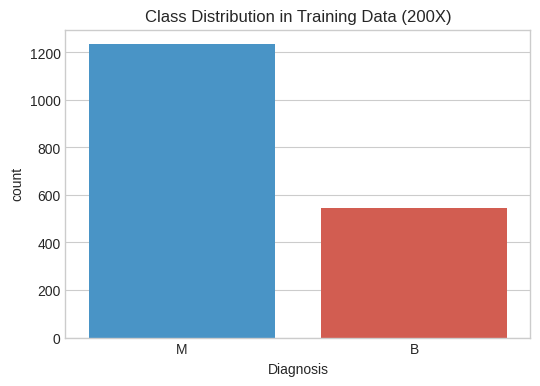


--- EDA: Univariate Feature Distributions (Training Data) ---


/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


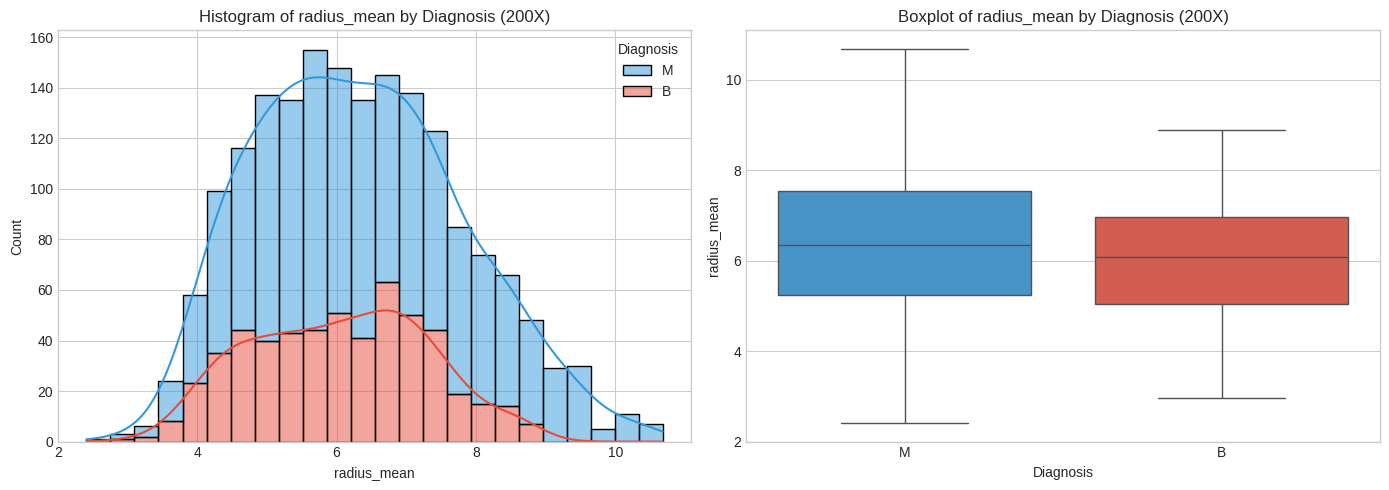

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


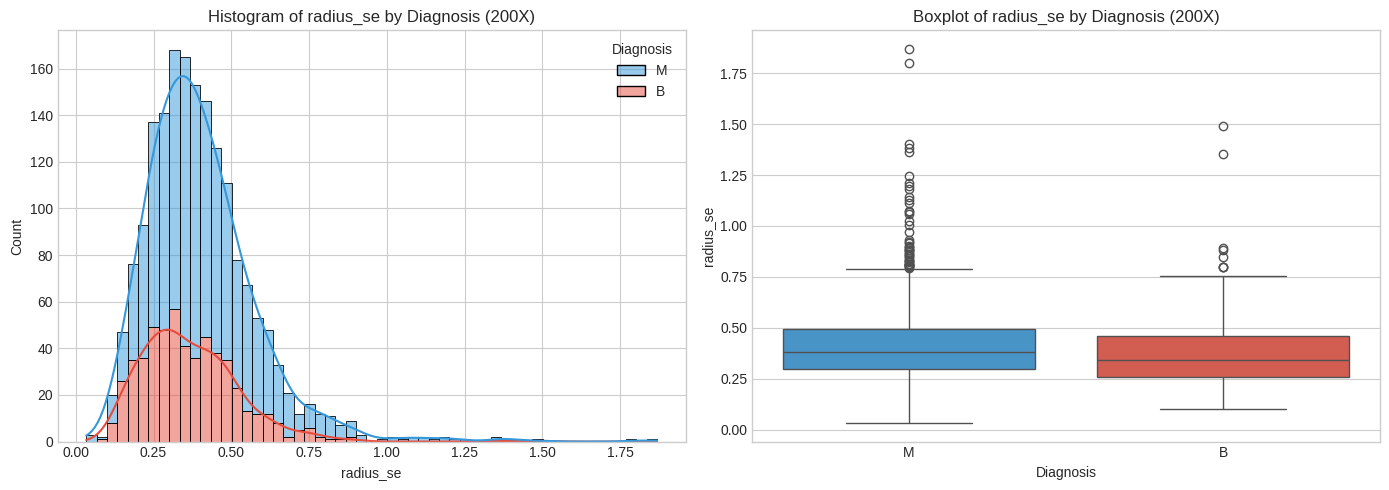

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


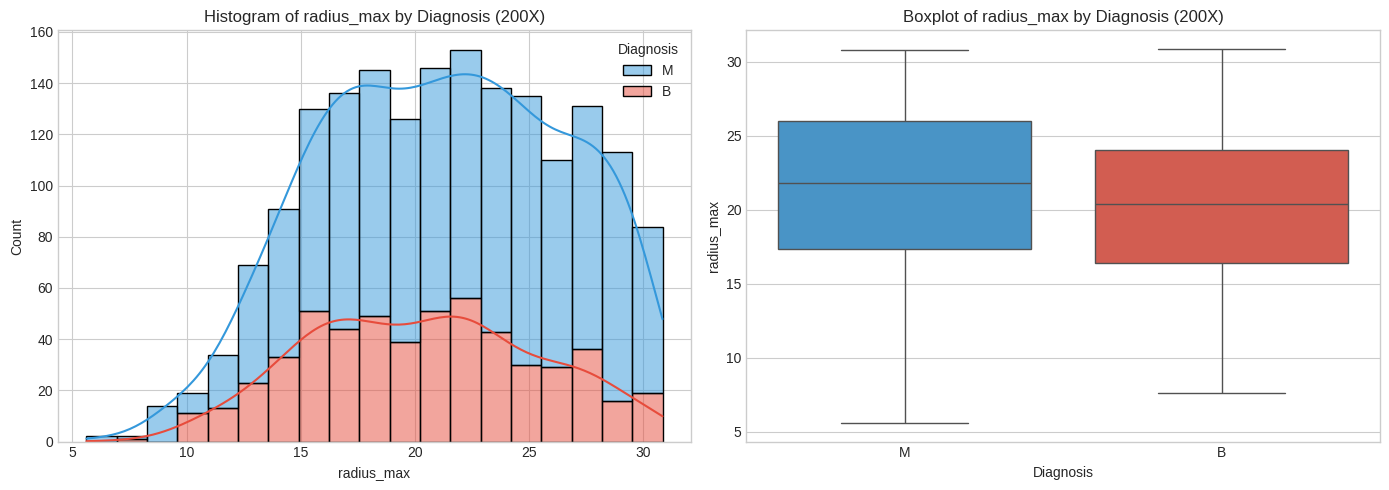

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


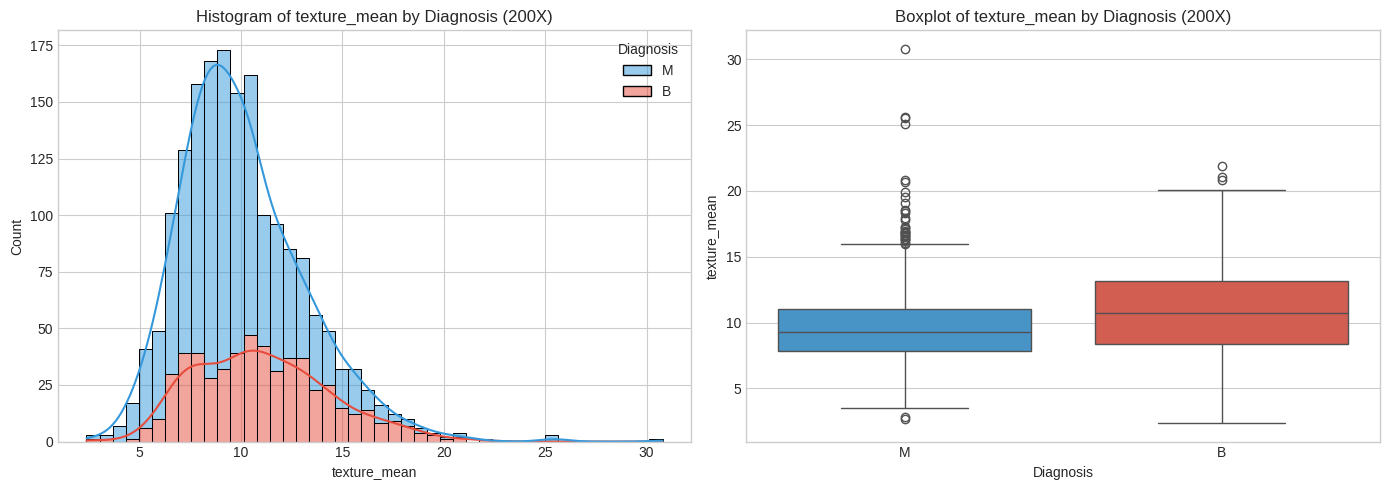

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


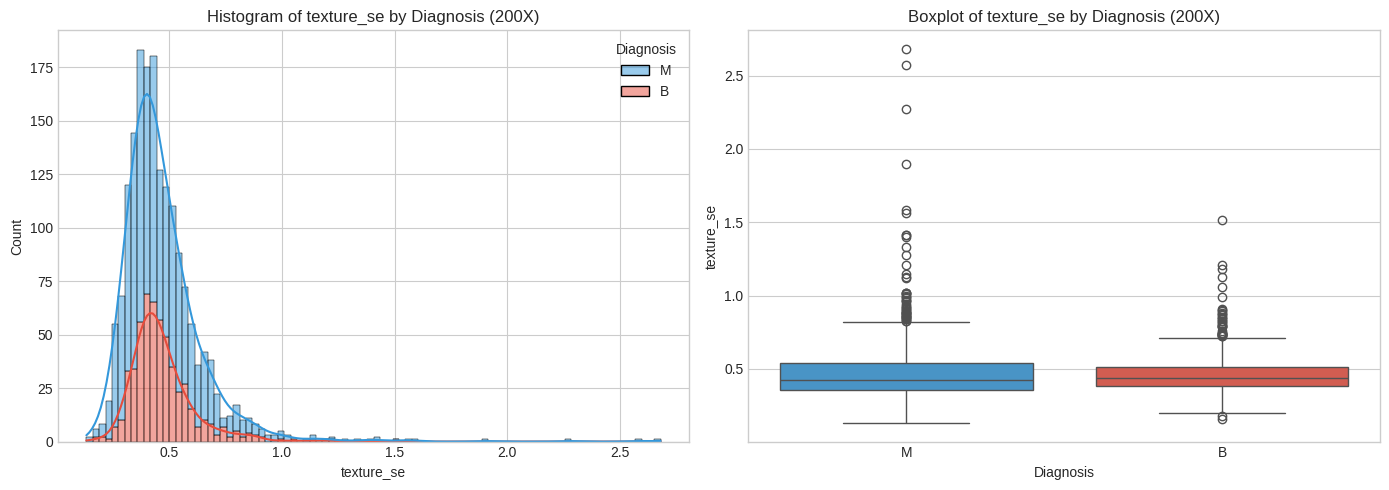

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


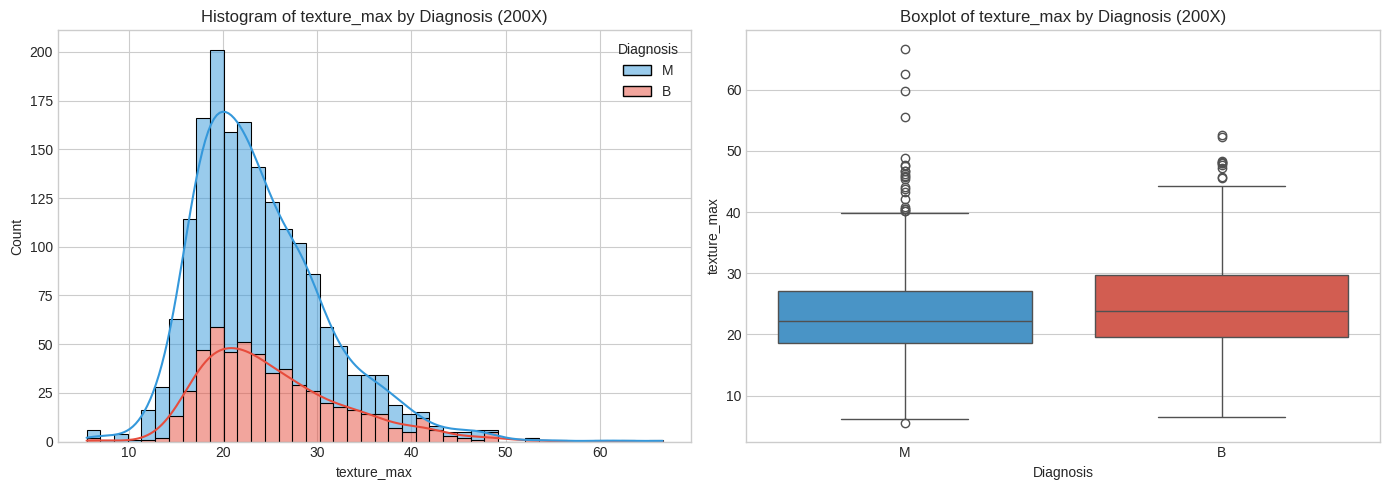

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


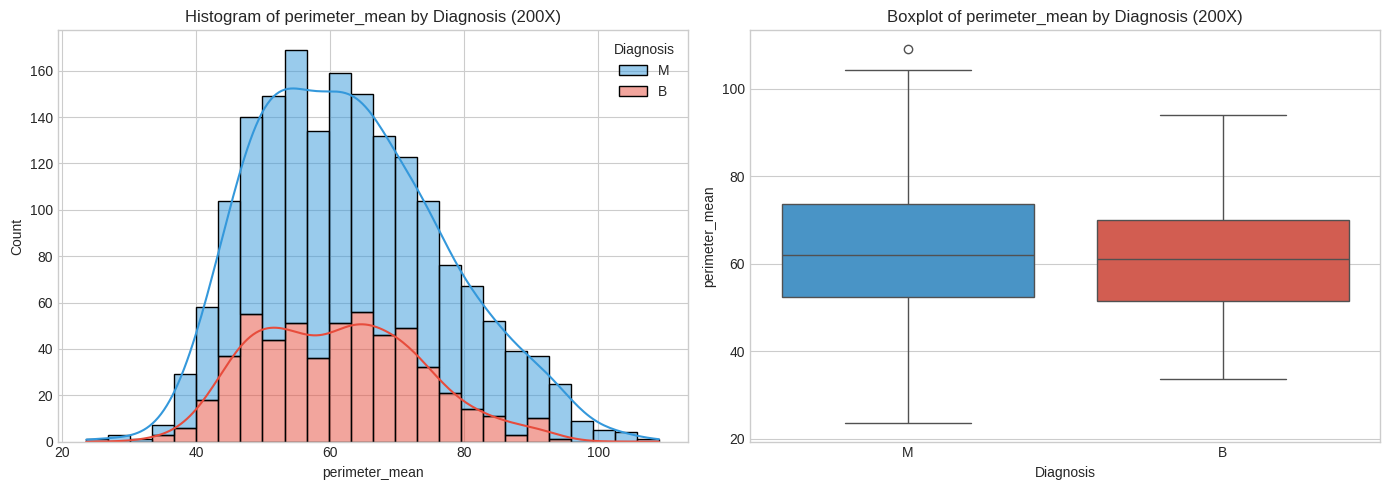

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


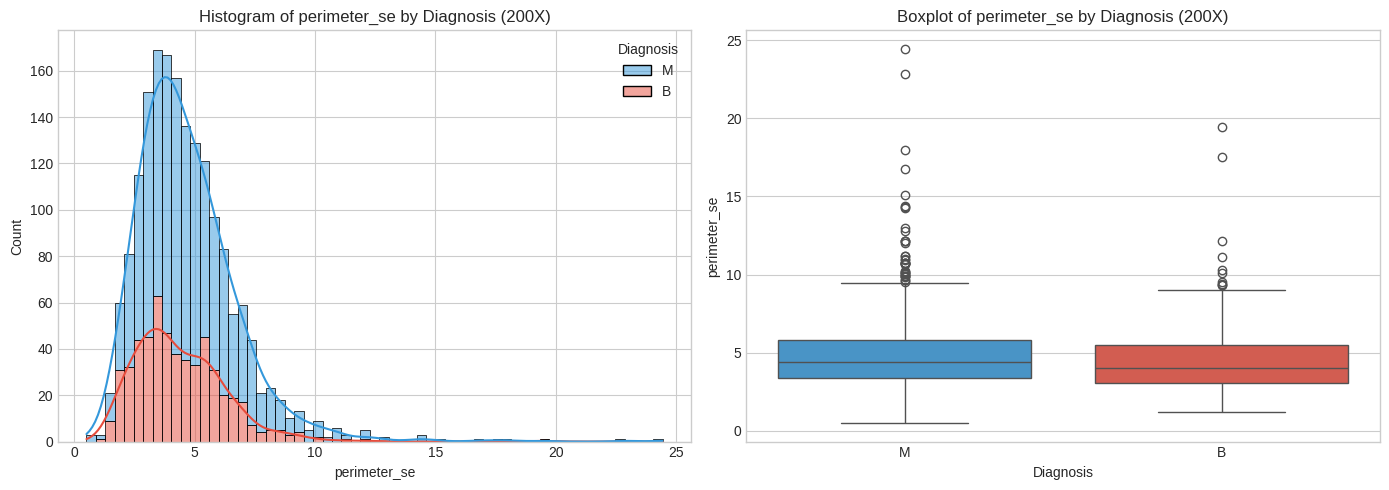

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


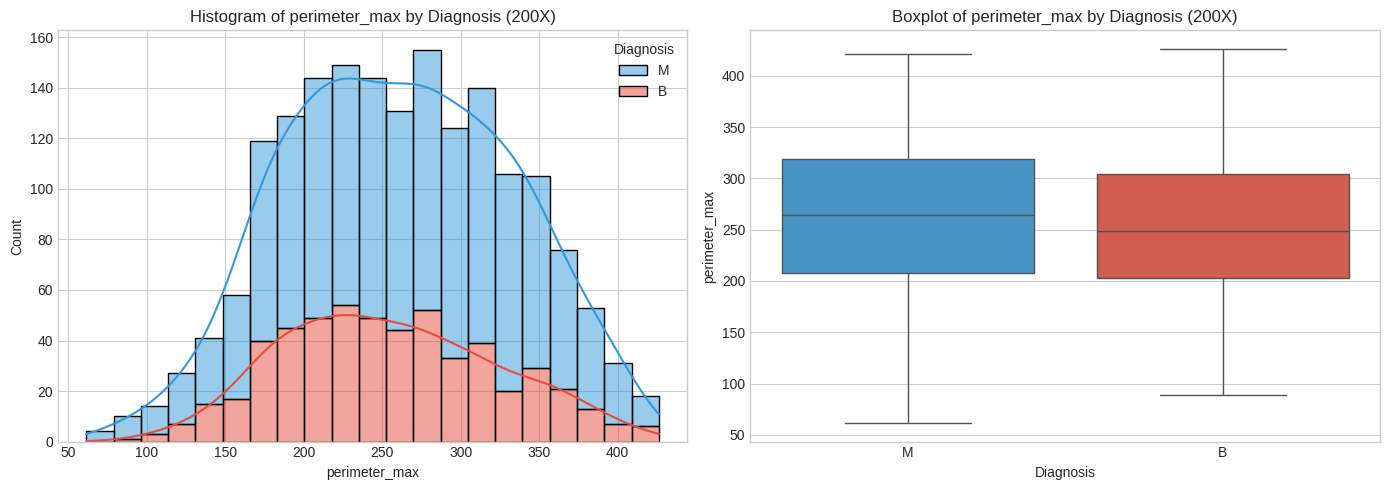

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


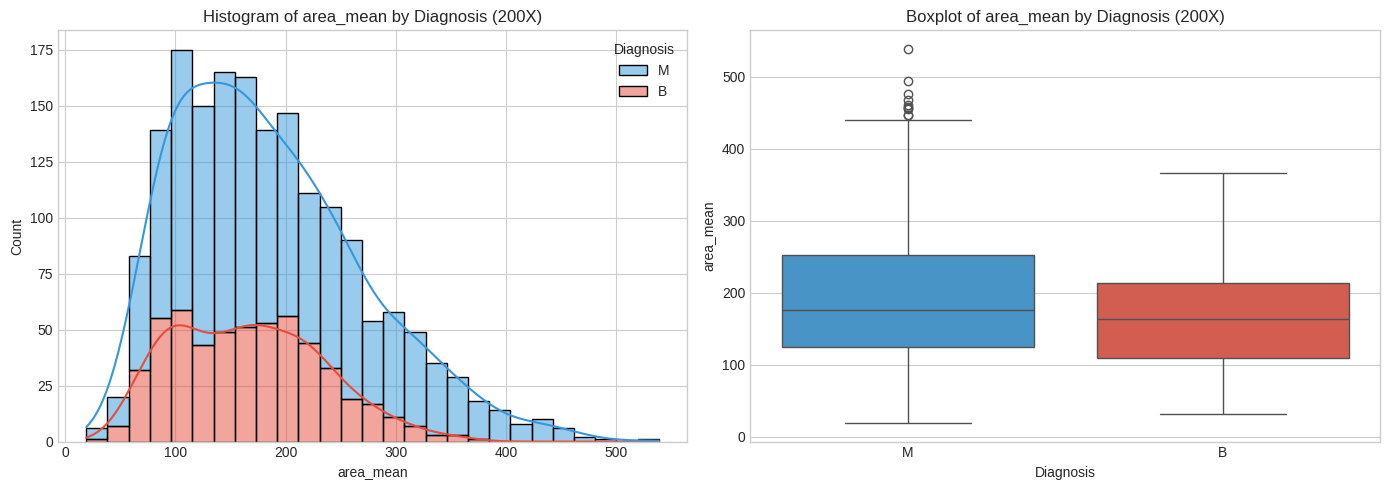

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


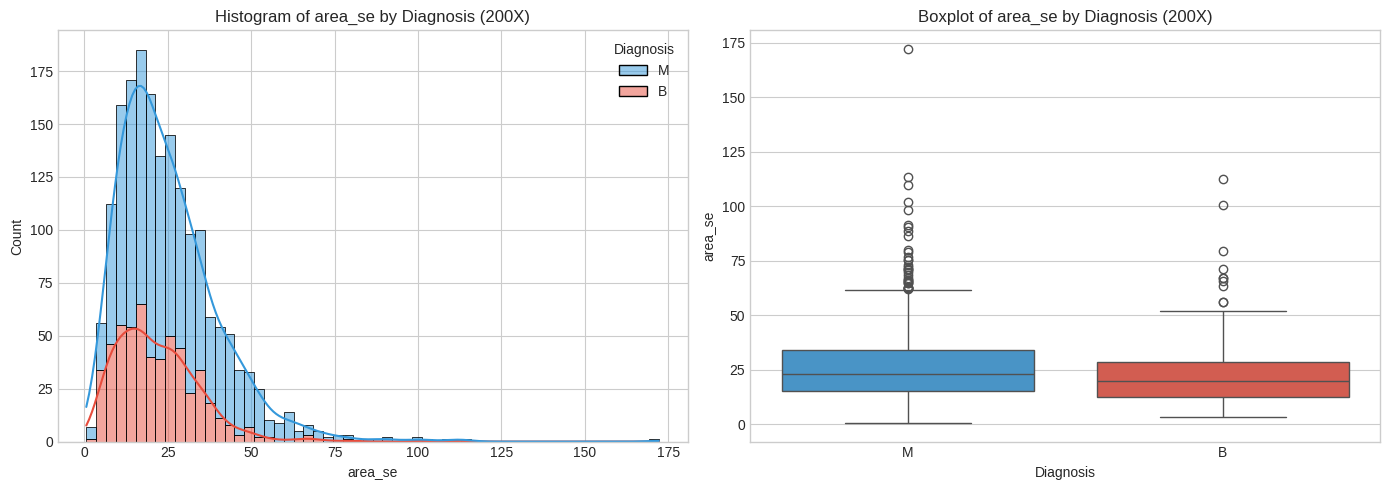

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


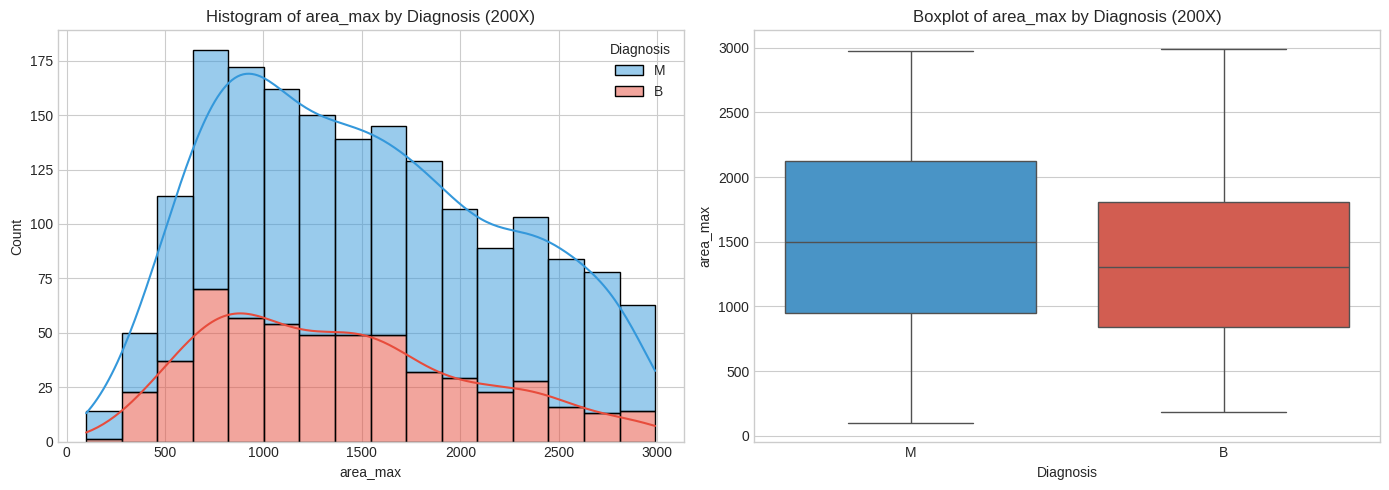

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


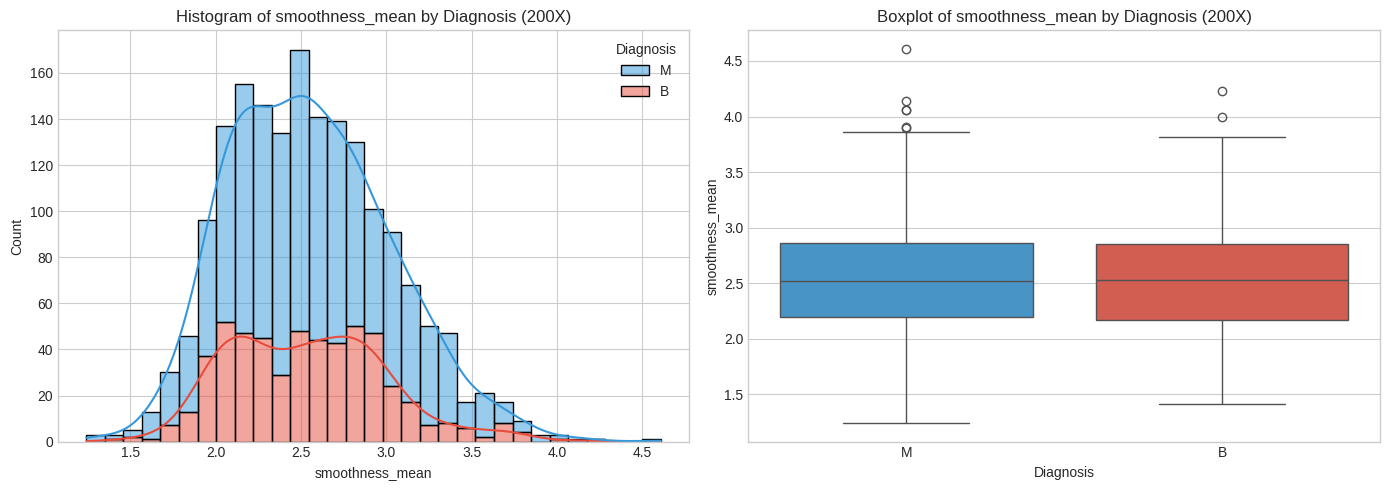

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


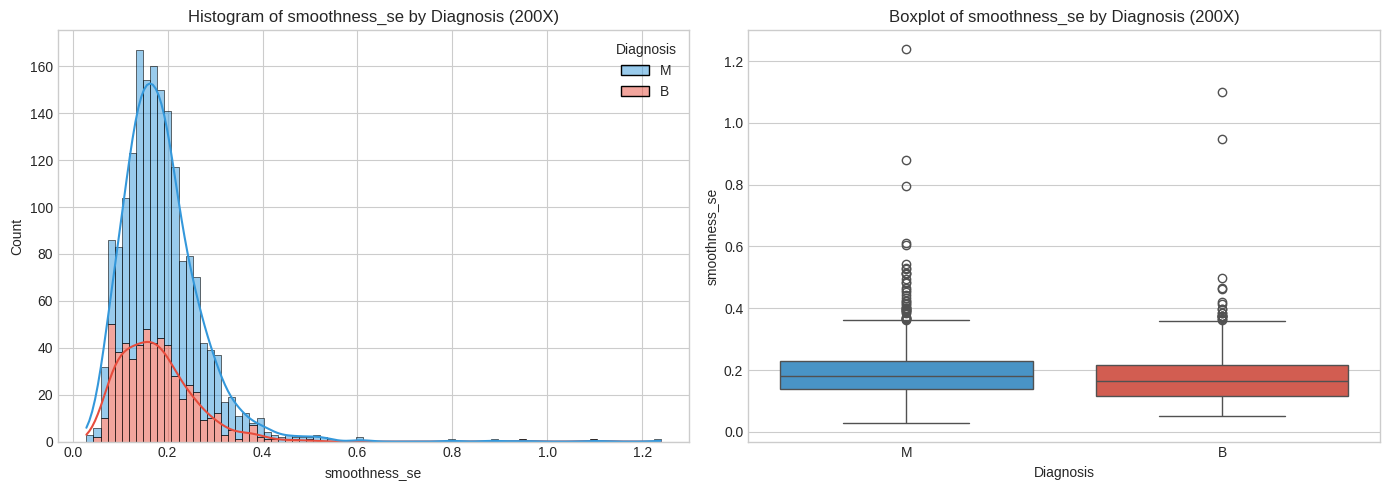

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


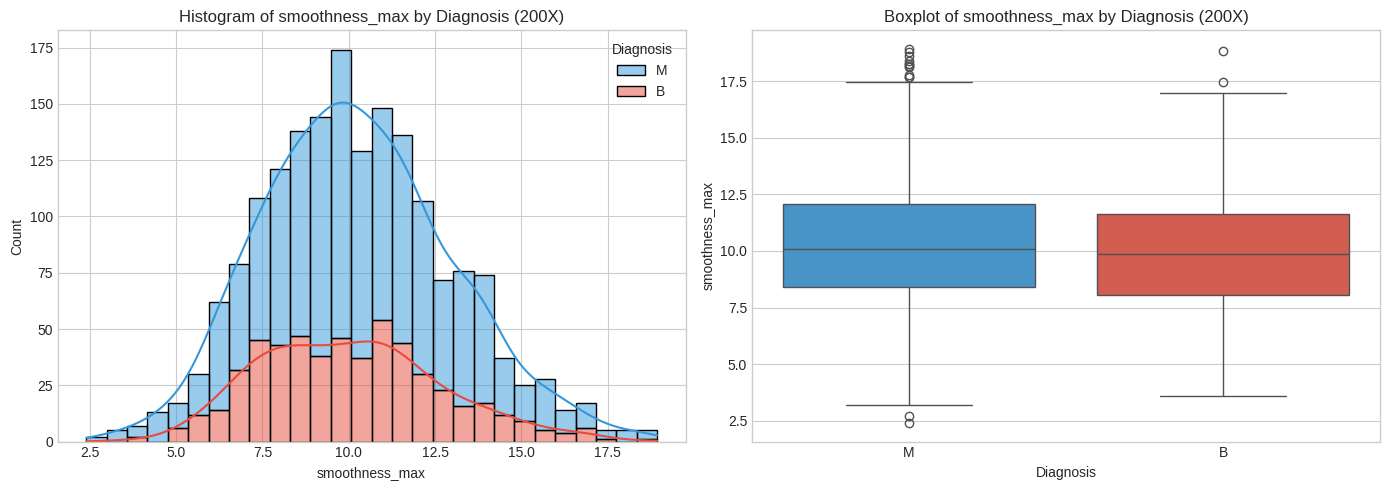

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


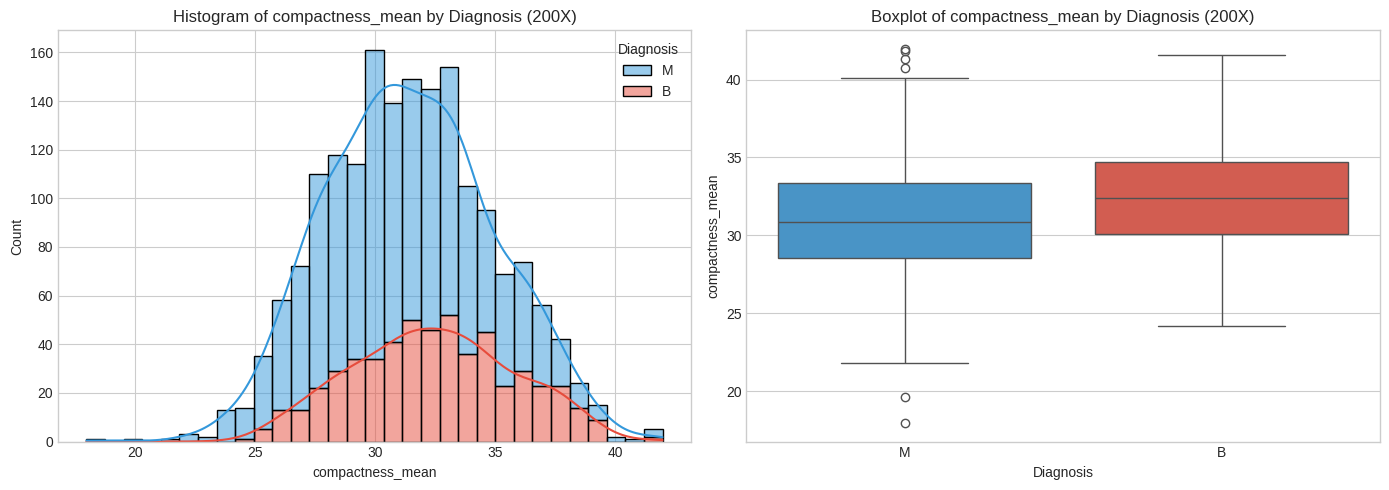

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


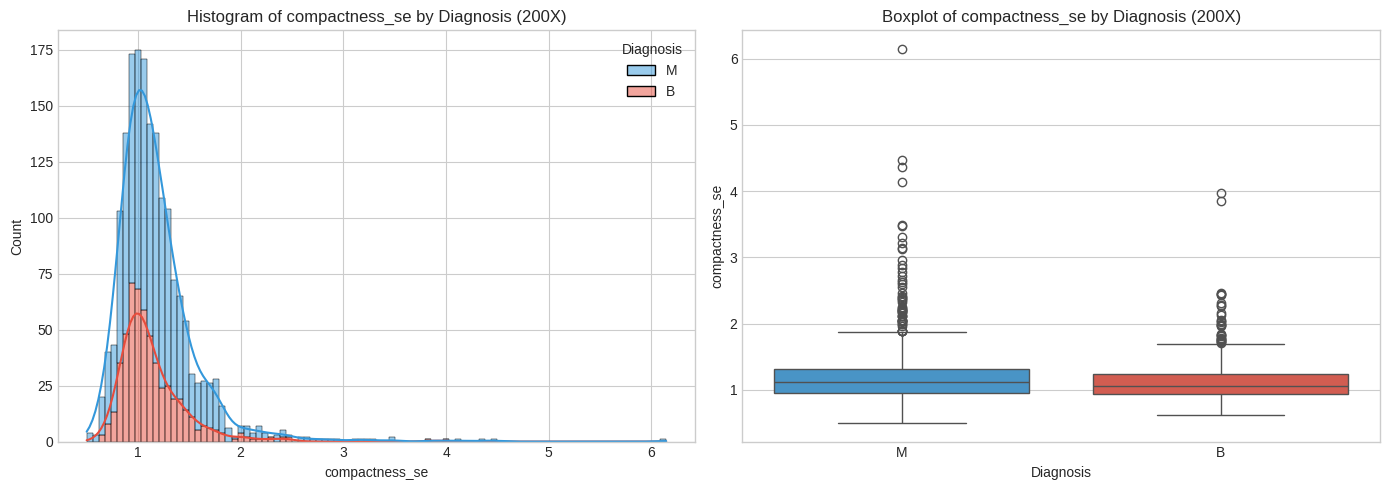

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


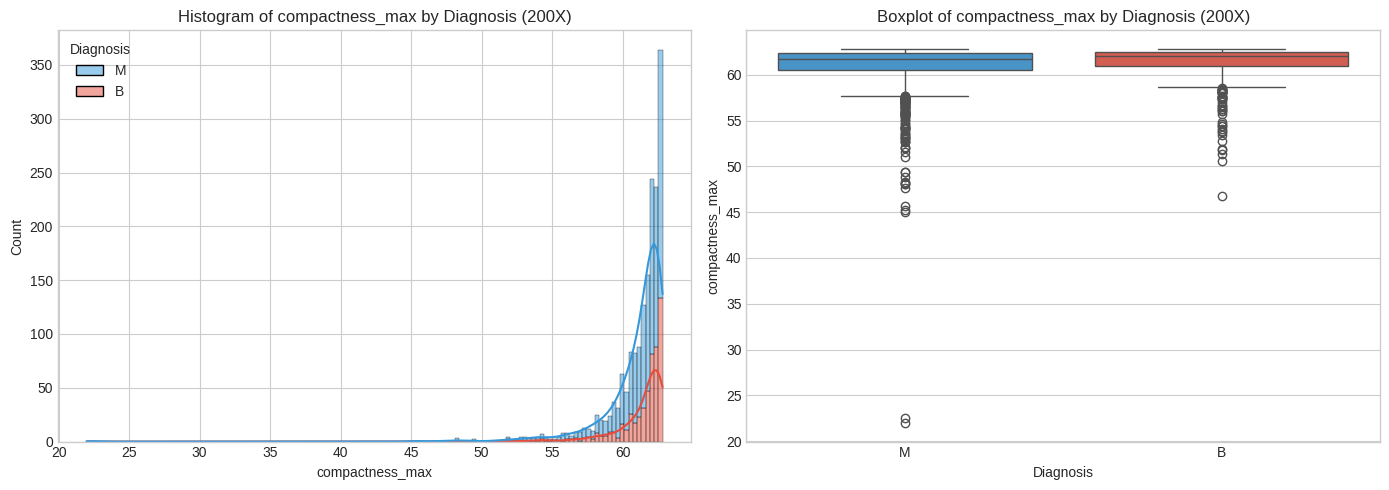

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


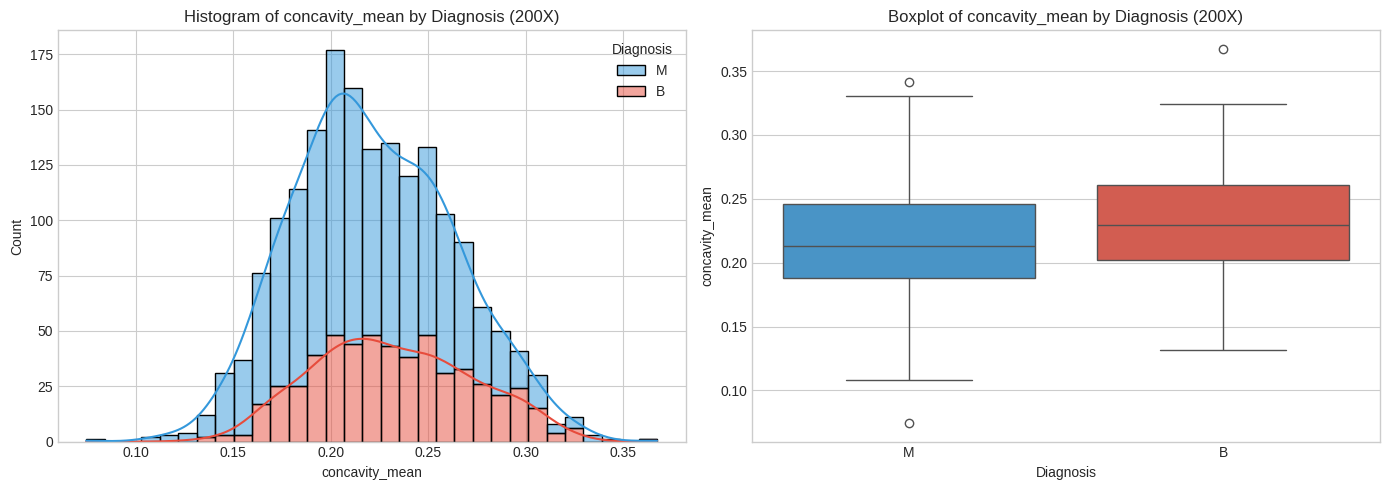

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


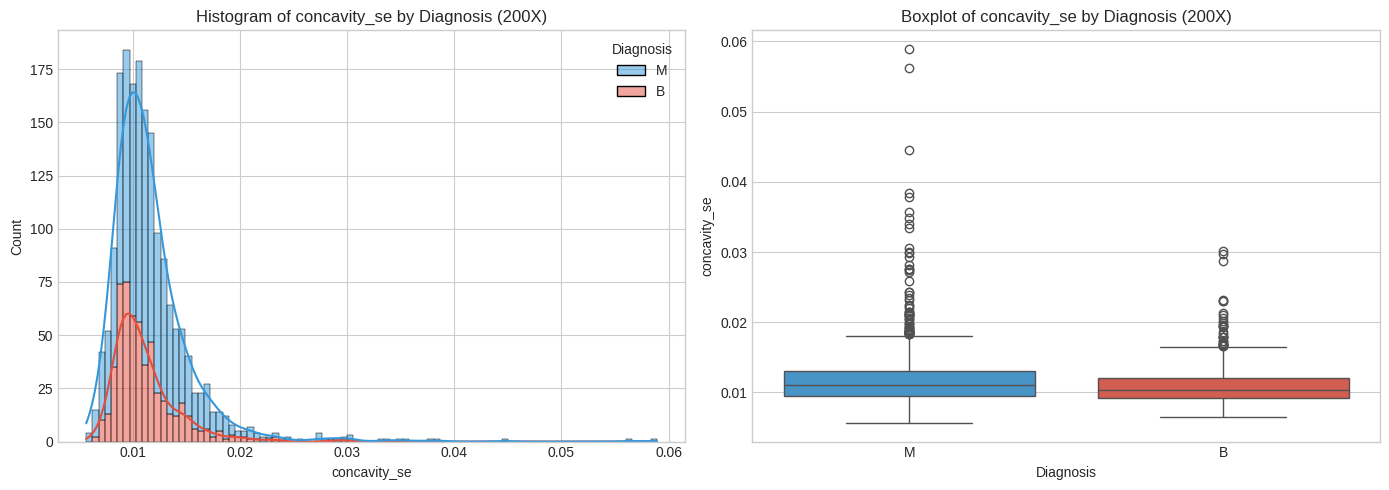

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


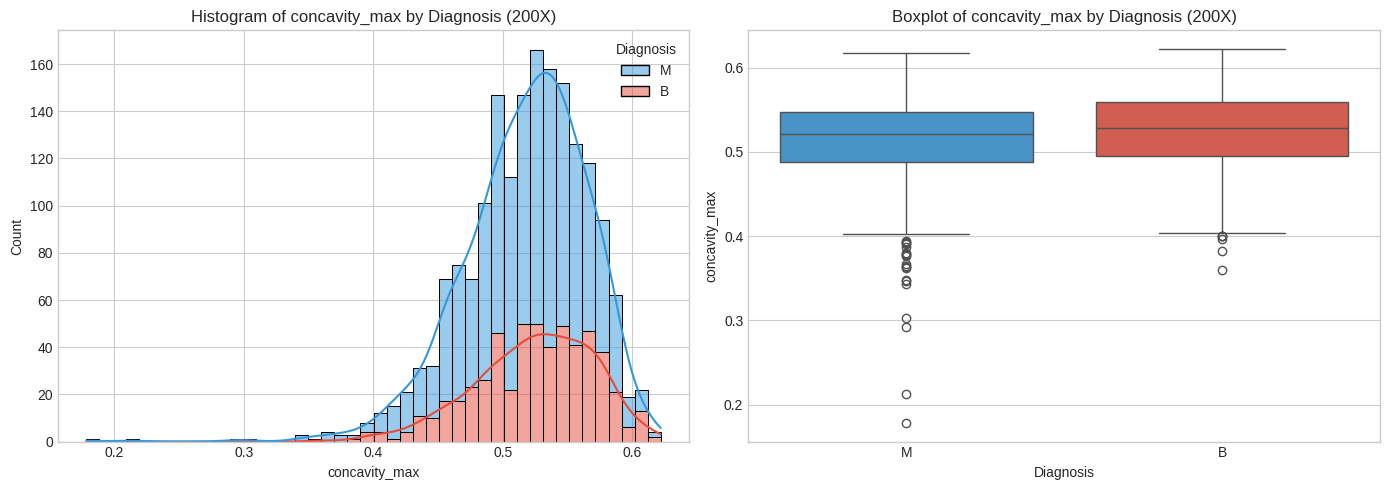

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


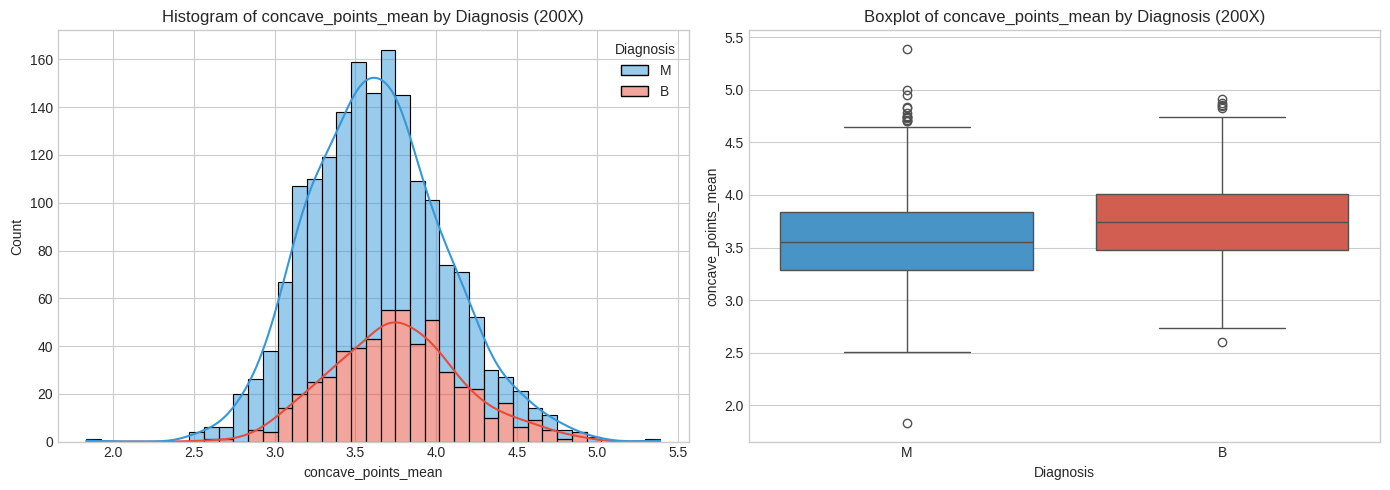

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


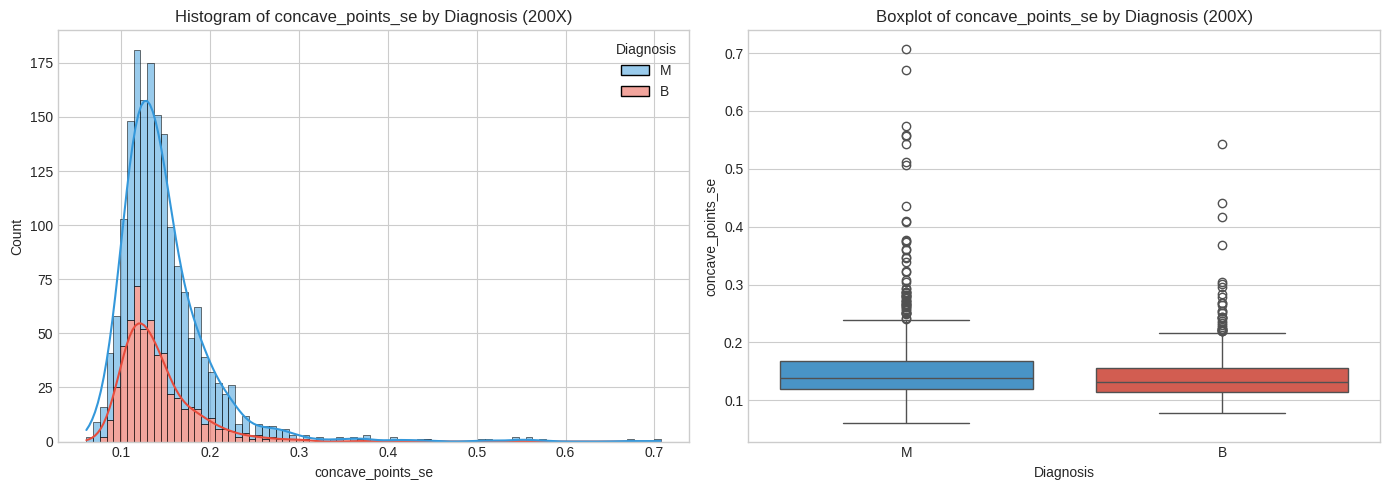

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


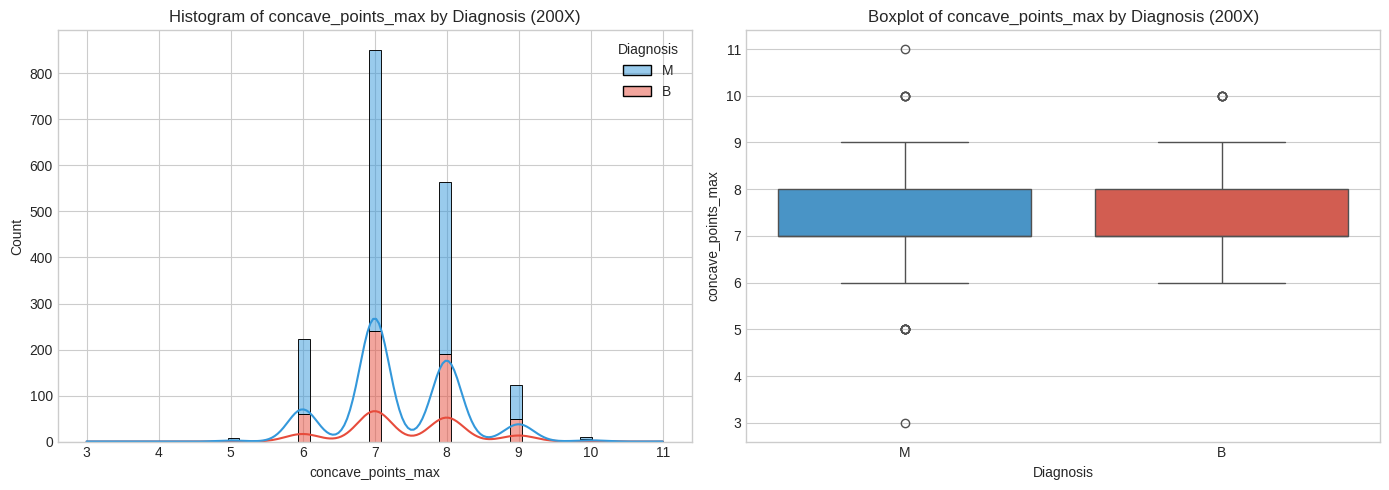

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


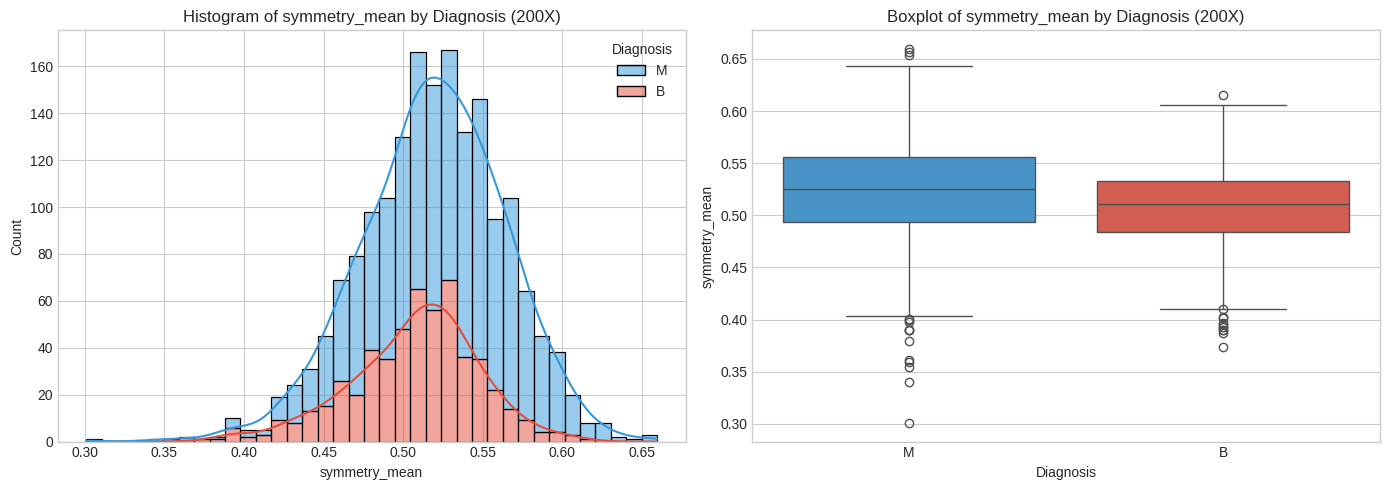

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


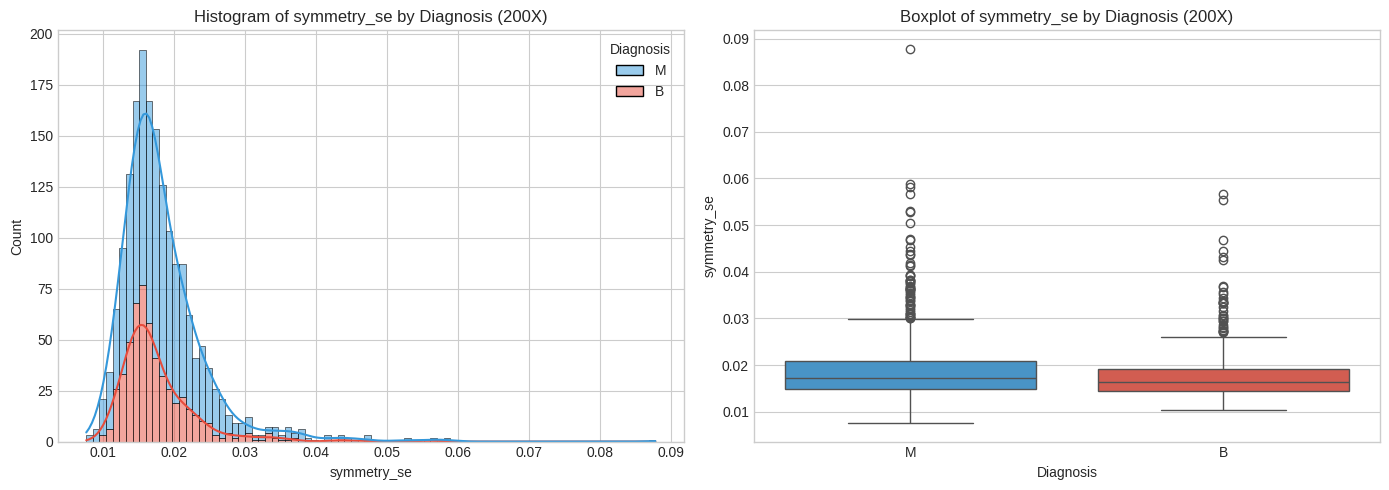

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


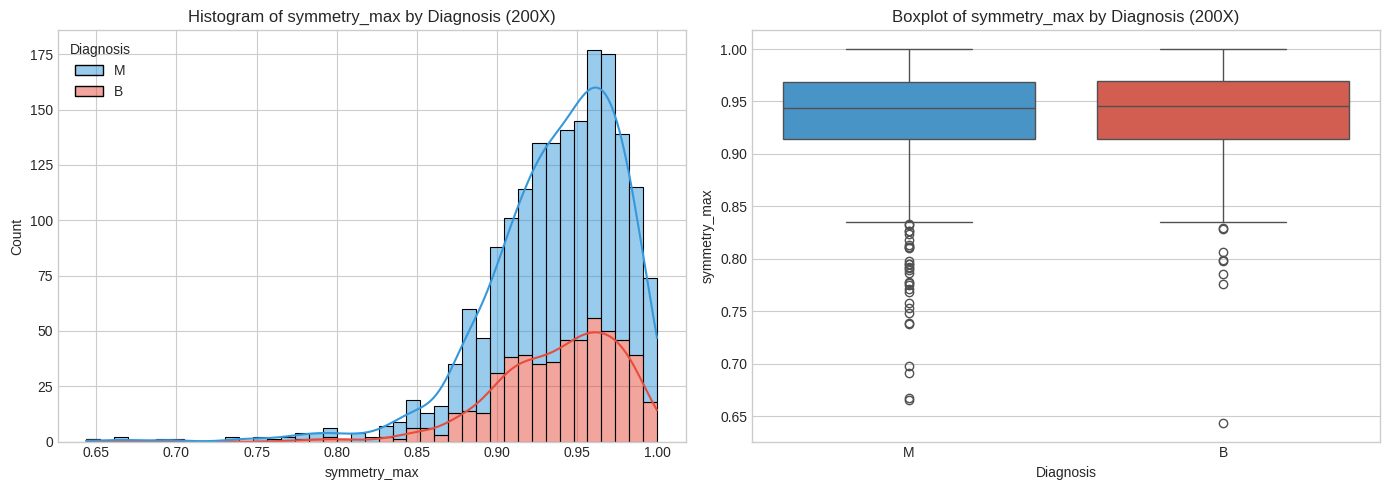

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


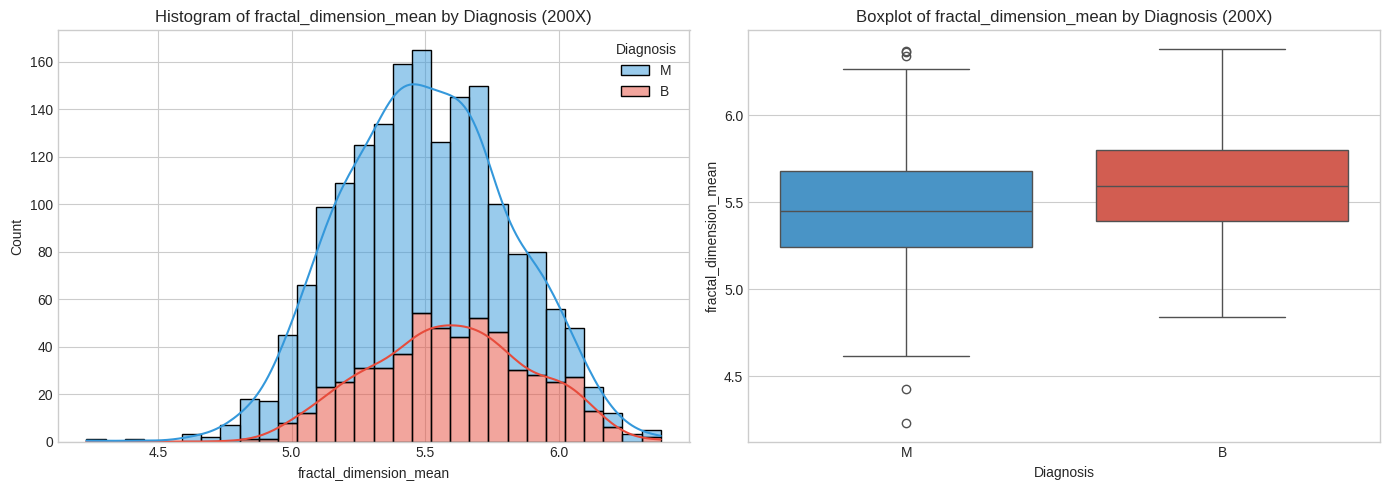

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


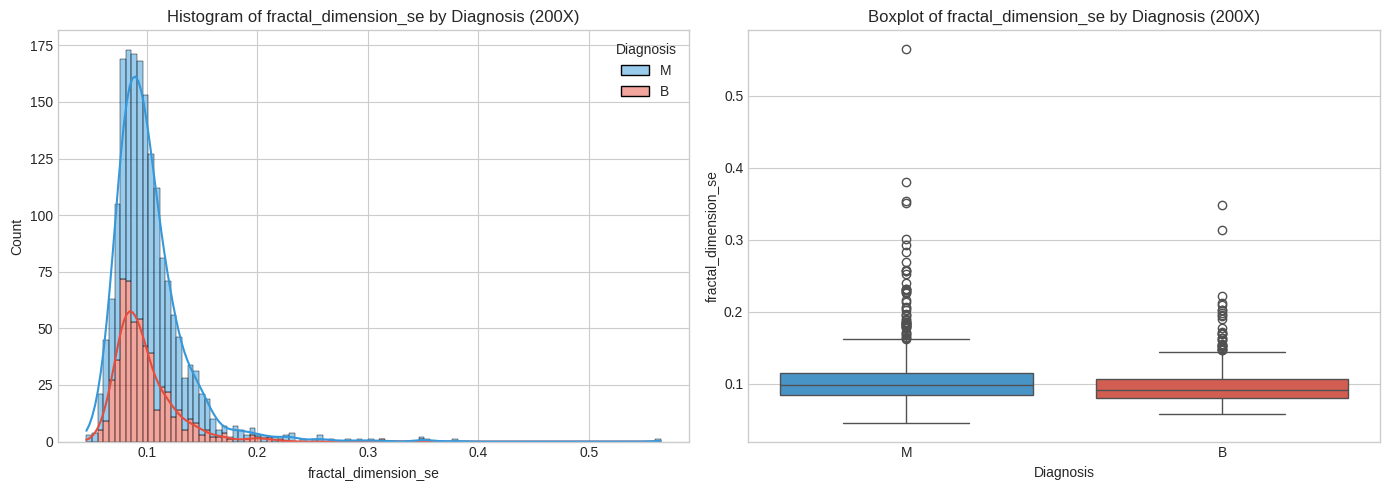

/tmp/ipykernel_261092/811843963.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])


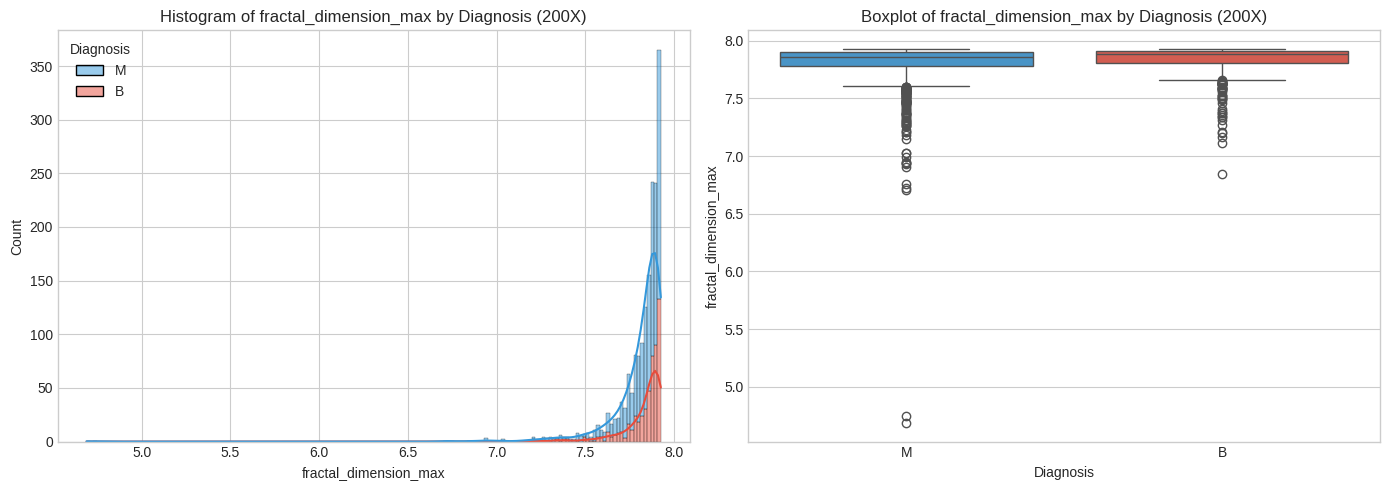


--- EDA: Feature Correlation Heatmap (Training Data) ---
                        radius_mean  radius_se  radius_max  texture_mean  \
radius_mean                1.000000   0.472313    0.643686     -0.059936   
radius_se                  0.472313   1.000000    0.396492     -0.355987   
radius_max                 0.643686   0.396492    1.000000     -0.148047   
texture_mean              -0.059936  -0.355987   -0.148047      1.000000   
texture_se                -0.090462   0.480869   -0.207027      0.186521   
texture_max               -0.293564  -0.453884   -0.217055      0.762172   
perimeter_mean             0.971096   0.518969    0.671541     -0.107232   
perimeter_se               0.478975   0.979530    0.434746     -0.340131   
perimeter_max              0.611227   0.337048    0.923390     -0.099739   
area_mean                  0.974591   0.556390    0.701915     -0.131589   
area_se                    0.588515   0.939331    0.617747     -0.310545   
area_max                   0.6

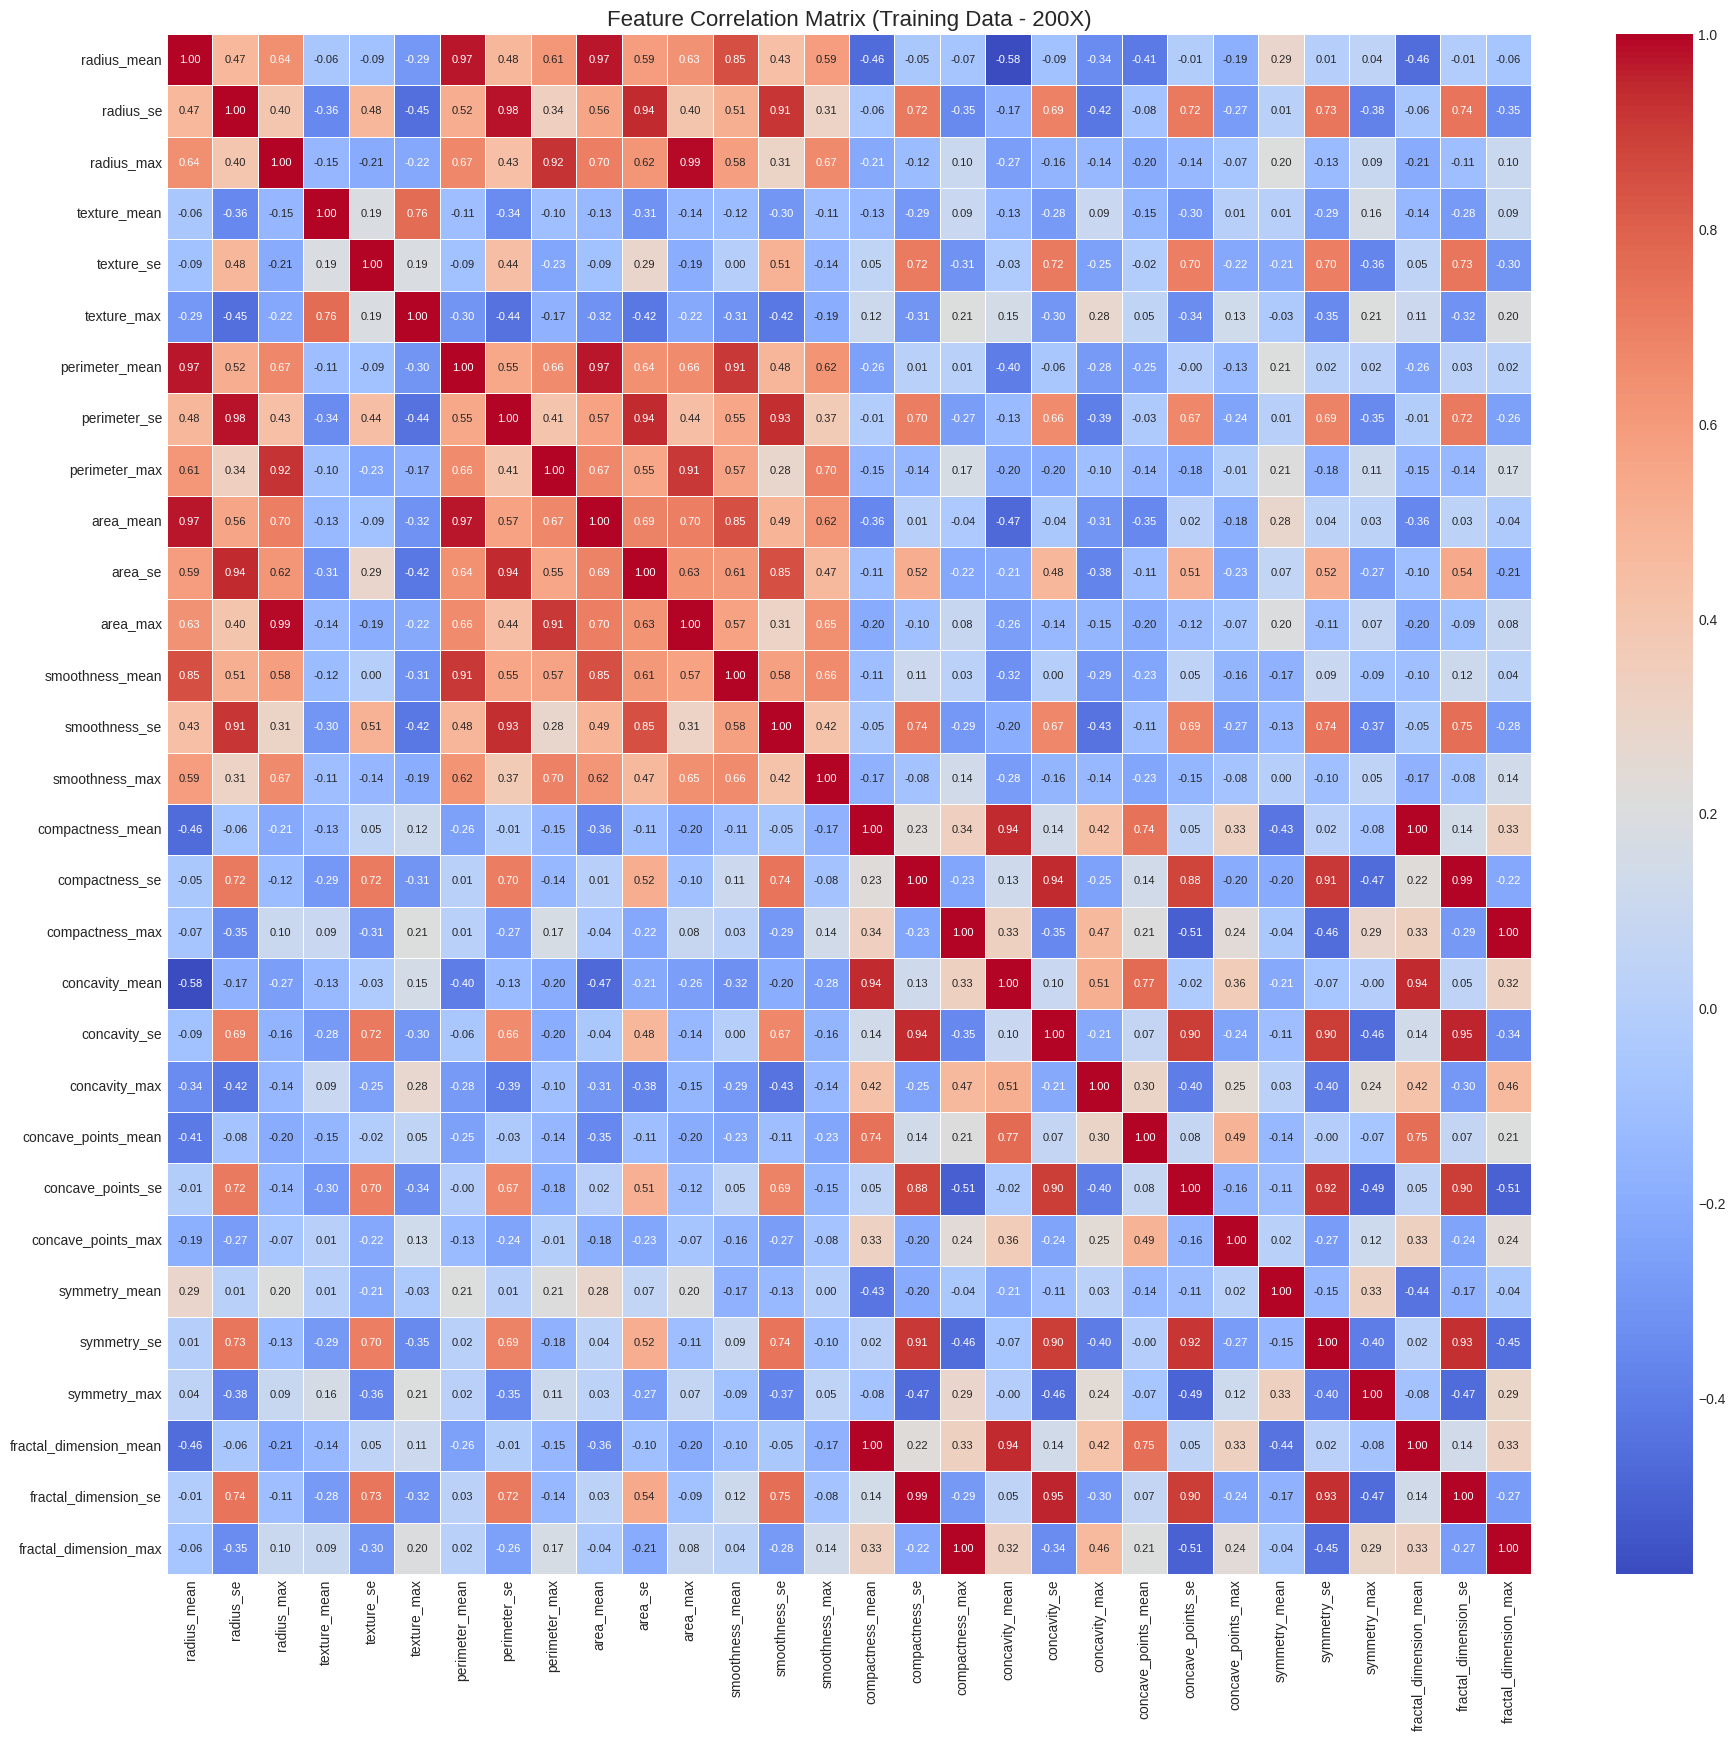


Highly Correlated Feature Pairs (abs(correlation) > 0.90) in Training Data:
compactness_mean and fractal_dimension_mean: 1.00
compactness_max and fractal_dimension_max: 1.00
compactness_se and fractal_dimension_se: 0.99
radius_max and area_max: 0.99
radius_se and perimeter_se: 0.98
radius_mean and area_mean: 0.97
perimeter_mean and area_mean: 0.97
radius_mean and perimeter_mean: 0.97
concavity_se and fractal_dimension_se: 0.95
perimeter_se and area_se: 0.94
compactness_se and concavity_se: 0.94
concavity_mean and fractal_dimension_mean: 0.94
compactness_mean and concavity_mean: 0.94
radius_se and area_se: 0.94
perimeter_se and smoothness_se: 0.93
symmetry_se and fractal_dimension_se: 0.93
radius_max and perimeter_max: 0.92
concave_points_se and symmetry_se: 0.92
radius_se and smoothness_se: 0.91
perimeter_max and area_max: 0.91
perimeter_mean and smoothness_mean: 0.91
compactness_se and symmetry_se: 0.91

--- EDA: Scatter Plots for Selected Feature Pairs (Training Data) ---


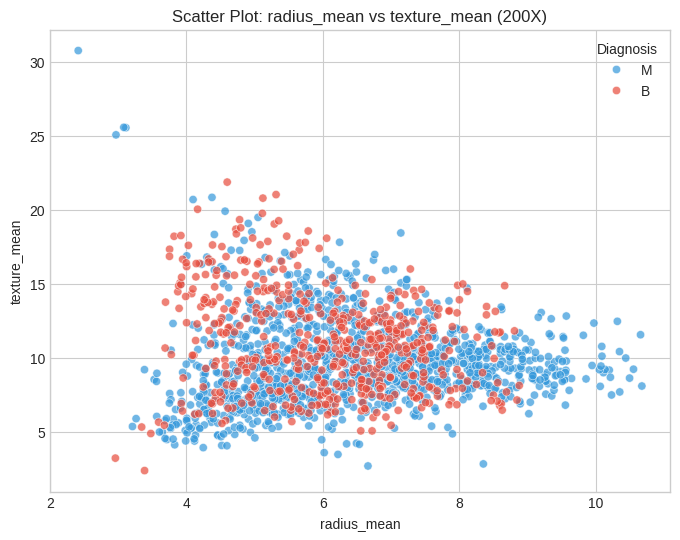

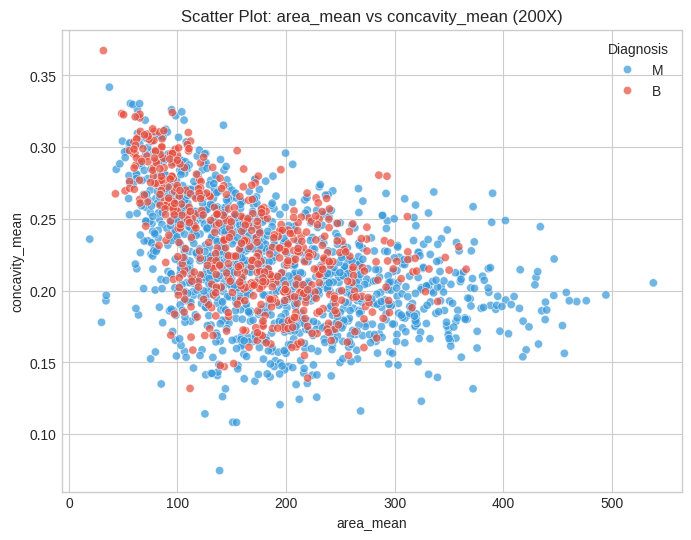

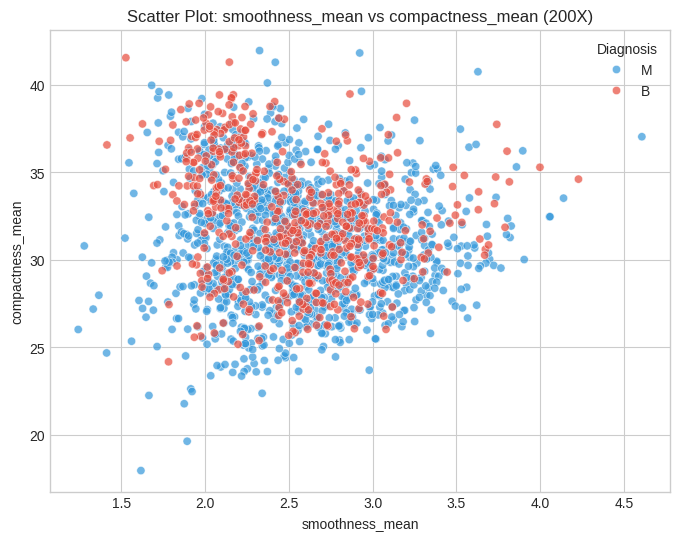

In [31]:
if not df_train_features.empty:
    print("\n--- EDA: Basic Training Feature Inspection ---")
    print(f"Shape: {df_train_features.shape}")
    print("\nData Types:\n", df_train_features.dtypes.value_counts())
    # df_train_features.info()

    print("\n--- EDA: Training Features Summary Statistics ---")
    print(df_train_features[FEATURE_COLUMNS].describe().T)

    print("\n--- EDA: Missing Values in Training Features (Before Imputation by Preprocessing Cell) ---")
    missing_values_train = df_train_features[FEATURE_COLUMNS].isnull().sum()
    missing_values_train_plot = missing_values_train[missing_values_train > 0]
    if not missing_values_train_plot.empty:
        print(missing_values_train_plot.sort_values(ascending=False))
        plt.figure(figsize=(12, 6))
        sns.barplot(x=missing_values_train_plot.index, y=missing_values_train_plot.values)
        plt.xticks(rotation=90)
        plt.title(f"Missing Values in Training Features ({TARGET_MAGNIFICATION})")
        plt.ylabel("Number of Missing Values")
        plt.show()
    else:
        print("No missing values in feature columns of the training set.")

    print("\n--- EDA: Class Distribution in Training Data ---")
    if 'Diagnosis' in df_train_features.columns:
        print(df_train_features['Diagnosis'].value_counts(normalize=True) * 100)
        plt.figure(figsize=(6,4))
        sns.countplot(x='Diagnosis', data=df_train_features, palette=['#3498db', '#e74c3c'])
        plt.title(f"Class Distribution in Training Data ({TARGET_MAGNIFICATION})")
        plt.show()
    
    print("\n--- EDA: Univariate Feature Distributions (Training Data) ---")
    for col in FEATURE_COLUMNS:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(data=df_train_features, x=col, hue='Diagnosis', kde=True, multiple="stack", palette=['#3498db', '#e74c3c'])
        plt.title(f'Histogram of {col} by Diagnosis ({TARGET_MAGNIFICATION})')
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df_train_features, x='Diagnosis', y=col, palette=['#3498db', '#e74c3c'])
        plt.title(f'Boxplot of {col} by Diagnosis ({TARGET_MAGNIFICATION})')
        plt.tight_layout()
        plt.show()

    print("\n--- EDA: Feature Correlation Heatmap (Training Data) ---")
    plt.figure(figsize=(22, 20)) 
    correlation_matrix_train = df_train_features[FEATURE_COLUMNS].corr()
    print(correlation_matrix_train)
    sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title(f'Feature Correlation Matrix (Training Data - {TARGET_MAGNIFICATION})', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    upper_tri = correlation_matrix_train.where(np.triu(np.ones(correlation_matrix_train.shape), k=1).astype(bool))
    highly_correlated_pairs_list = []
    for column in upper_tri.columns:
        for idx in upper_tri.index:
            if abs(upper_tri.loc[idx, column]) > 0.90:
                highly_correlated_pairs_list.append((idx, column, upper_tri.loc[idx, column]))
    
    if highly_correlated_pairs_list:
        print("\nHighly Correlated Feature Pairs (abs(correlation) > 0.90) in Training Data:")
        for pair in sorted(list(set(highly_correlated_pairs_list)), key=lambda x: abs(x[2]), reverse=True):
             print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
    else:
        print("No feature pairs with absolute correlation > 0.90 found in training data.")

    # Scatter plots for a few select pairs (example)
    # Choose pairs that are interesting, not necessarily the most correlated if one is a derivative of another
    print("\n--- EDA: Scatter Plots for Selected Feature Pairs (Training Data) ---")
    scatter_pairs = [
        ('radius_mean', 'texture_mean'), 
        ('area_mean', 'concavity_mean'),
        ('smoothness_mean', 'compactness_mean')
    ]
    for pair in scatter_pairs:
        if pair[0] in df_train_features.columns and pair[1] in df_train_features.columns:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df_train_features, x=pair[0], y=pair[1], hue='Diagnosis', palette=['#3498db', '#e74c3c'], alpha=0.7)
            plt.title(f'Scatter Plot: {pair[0]} vs {pair[1]} ({TARGET_MAGNIFICATION})')
            plt.show()
else:
    print("Skipping EDA as df_train_features is empty.")



## 7. Data Cleaning & Preprocessing


In [32]:
scaler = StandardScaler()
le = LabelEncoder()
imputer = SimpleImputer(strategy='mean')

X_train_scaled = pd.DataFrame()
y_train = np.array([])
X_test_scaled = pd.DataFrame()
y_test = np.array([])

if not df_train_features.empty:
    print("\n--- Preprocessing Training Data ---")
    df_train_clean = df_train_features.copy()
    initial_train_rows = df_train_clean.shape[0]
    nan_rows_train_count = df_train_clean[FEATURE_COLUMNS].isnull().any(axis=1).sum()
    if nan_rows_train_count > 0:
        if NAN_HANDLING_STRATEGY == 'drop':
            print(f"Strategy: Dropping {nan_rows_train_count} training rows with NaNs in features.")
            df_train_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
        elif NAN_HANDLING_STRATEGY == 'impute_mean':
            print(f"Strategy: Imputing NaNs in training features with column mean.")
            df_train_clean[FEATURE_COLUMNS] = imputer.fit_transform(df_train_clean[FEATURE_COLUMNS])
    print(f"Training rows after NaN handling: {df_train_clean.shape[0]} (out of {initial_train_rows})")

    if not df_train_clean.empty:
        X_train = df_train_clean[FEATURE_COLUMNS]
        y_train_raw = df_train_clean['Diagnosis']
        y_train = le.fit_transform(y_train_raw)
        print(f"Target variable 'Diagnosis' encoded. Classes: {le.classes_}")
        X_train_scaled_np = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=FEATURE_COLUMNS, index=X_train.index)
        print("Training features scaled.")
    else:
        print("Training data is empty after NaN handling. Cannot proceed with training.")
else:
    print("\nTraining features dataframe is empty. Cannot preprocess.")

if not df_test_features.empty and not X_train_scaled.empty:
    print("\n--- Preprocessing Testing Data ---")
    df_test_clean = df_test_features.copy()
    initial_test_rows = df_test_clean.shape[0]
    nan_rows_test_count = df_test_clean[FEATURE_COLUMNS].isnull().any(axis=1).sum()
    if nan_rows_test_count > 0:
        if NAN_HANDLING_STRATEGY == 'drop':
            print(f"Strategy: Dropping {nan_rows_test_count} testing rows with NaNs in features.")
            df_test_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
        elif NAN_HANDLING_STRATEGY == 'impute_mean':
            print(f"Strategy: Imputing NaNs in testing features using imputer fitted on training data.")
            try:
                df_test_clean[FEATURE_COLUMNS] = imputer.transform(df_test_clean[FEATURE_COLUMNS])
            except NotFittedError:
                print("Error: Imputer not fitted. Dropping test NaNs.")
                df_test_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
            except Exception as e:
                print(f"Error imputing test NaNs: {e}. Dropping test NaNs.")
                df_test_clean.dropna(subset=FEATURE_COLUMNS, inplace=True)
    print(f"Testing rows after NaN handling: {df_test_clean.shape[0]} (out of {initial_test_rows})")

    if not df_test_clean.empty:
        X_test = df_test_clean[FEATURE_COLUMNS]
        y_test_raw = df_test_clean['Diagnosis']
        try:
            y_test = le.transform(y_test_raw)
            print("Test target encoded.")
        except ValueError as e: 
            print(f"Warning: Error encoding test labels: {e}.")
            y_test = np.array([-1] * len(y_test_raw))
        try:
            X_test_scaled_np = scaler.transform(X_test)
            X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=FEATURE_COLUMNS, index=X_test.index)
            print("Testing features scaled.")
        except NotFittedError:
            print("Error: Scaler not fitted. Cannot scale test data.")
            X_test_scaled = pd.DataFrame()
        except Exception as e:
            print(f"Error scaling test data: {e}")
            X_test_scaled = pd.DataFrame()
    else:
        print("Testing data is empty after NaN handling.")
elif df_test_features.empty:
    print("\nTesting features dataframe is empty. Cannot preprocess.")
else:
    print("\nTraining data was not processed. Skipping test data preprocessing.")


--- Preprocessing Training Data ---
Training rows after NaN handling: 1778 (out of 1778)
Target variable 'Diagnosis' encoded. Classes: ['B' 'M']
Training features scaled.

--- Preprocessing Testing Data ---
Testing rows after NaN handling: 235 (out of 235)
Test target encoded.
Testing features scaled.


## 8. Model Training


In [33]:
models = {} 
model_accuracies = {}
model_cms = {}
model_roc_aucs = {}

if not X_train_scaled.empty and y_train.size > 0:
    print("\n--- Training All Models ---")

    # 1. Support Vector Classification (SVC) with GridSearchCV
    print("\nTraining Support Vector Classifier with GridSearchCV...")
    svc_param_grid = {
        'C': [0.1, 1, 10, 50, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }
    base_svc = SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')
    cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    svc_grid_search = GridSearchCV(estimator=base_svc, param_grid=svc_param_grid, cv=cv_stratified, 
                                 scoring='f1_weighted', verbose=1, n_jobs=-1)
    try:
        svc_grid_search.fit(X_train_scaled, y_train)
        print(f"SVC Best Params: {svc_grid_search.best_params_}")
        print(f"SVC Best CV Score (f1_weighted): {svc_grid_search.best_score_:.4f}")
        models['SVC'] = svc_grid_search.best_estimator_
        print("SVC Model Trained and Tuned.")
    except Exception as e:
        print(f"Error training/tuning SVC: {e}")
        models['SVC'] = None

    # 2. XGBoost Classifier
    print("\nTraining XGBoost Classifier...")
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                                  use_label_encoder=False, random_state=RANDOM_STATE, 
                                  scale_pos_weight= (sum(y_train==0)/sum(y_train==1)) if sum(y_train==1)>0 else 1) # Handle class imbalance
    try:
        xgb_model.fit(X_train_scaled, y_train)
        models['XGBoost'] = xgb_model
        print("XGBoost Model Trained.")
    except Exception as e:
        print(f"Error training XGBoost: {e}")
        models['XGBoost'] = None

    # 3. Random Forest Classifier
    print("\nTraining Random Forest Classifier...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced_subsample') # or 'balanced'
    try:
        rf_model.fit(X_train_scaled, y_train)
        models['RandomForest'] = rf_model
        print("Random Forest Model Trained.")
    except Exception as e:
        print(f"Error training Random Forest: {e}")
        models['RandomForest'] = None

    # 4. Neural Network Classifier (MLP)
    print("\nTraining Neural Network (MLP) Classifier...")
    mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=RANDOM_STATE, 
                              activation='relu', solver='adam', alpha=0.0001, 
                              early_stopping=True, n_iter_no_change=10, learning_rate_init=0.001)
    try:
        mlp_model.fit(X_train_scaled, y_train)
        models['MLP'] = mlp_model
        print("MLP Model Trained.")
    except Exception as e:
        print(f"Error training MLP: {e}")
        models['MLP'] = None
        
    # 5. Logistic Regression
    print("\nTraining Logistic Regression Classifier...")
    lr_model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced', C=1.0, max_iter=200)
    try:
        lr_model.fit(X_train_scaled, y_train)
        models['LogisticRegression'] = lr_model
        print("Logistic Regression Model Trained.")
    except Exception as e:
        print(f"Error training Logistic Regression: {e}")
        models['LogisticRegression'] = None
else:
    print("\nSkipping model training due to lack of processed training data or labels.")


--- Training All Models ---

Training Support Vector Classifier with GridSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
SVC Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC Best CV Score (f1_weighted): 0.7636
SVC Model Trained and Tuned.

Training XGBoost Classifier...


/home/sih/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:23:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Trained.

Training Random Forest Classifier...
Random Forest Model Trained.

Training Neural Network (MLP) Classifier...
MLP Model Trained.

Training Logistic Regression Classifier...
Logistic Regression Model Trained.


# 9. Model Evaluation

This section now uses the `TARGET_MAGNIFICATION` in plot titles and file names.

In [34]:
def evaluate_model(model_name, model, X_test_data, y_true_encoded, le_encoder, target_magnification):
    print(f"\n--- Evaluation Metrics for: {model_name} on Test Set ({target_magnification}) ---")
    figures_output_dir = PROJ_ROOT_DIR / 'reports' / 'figures' / target_magnification
    figures_output_dir.mkdir(parents=True, exist_ok=True)
    reports_output_dir = PROJ_ROOT_DIR / 'reports' / target_magnification
    reports_output_dir.mkdir(parents=True, exist_ok=True)

    if model is None: 
        print("Model was not trained or training failed."); return 0.0, None, None
    if X_test_data.empty: 
        print("Test data is empty."); return 0.0, None, None
    if len(y_true_encoded) == 0 or (isinstance(y_true_encoded, np.ndarray) and np.all(y_true_encoded == -1)): 
        print("Test labels are invalid or empty."); return 0.0, None, None
    
    y_pred, y_prob = None, None
    try:
        y_pred = model.predict(X_test_data)
        if hasattr(model, "predict_proba"):
             y_prob = model.predict_proba(X_test_data)[:, 1] 
        else:
            print(f"Model {model_name} does not support predict_proba, ROC AUC cannot be calculated.")
    except NotFittedError:
        print(f"Error: Model {model_name} is not fitted. Cannot make predictions.")
        return 0.0, None, None
    except Exception as e: 
        print(f"Error during prediction for {model_name}: {e}"); return 0.0, None, None

    accuracy = accuracy_score(y_true_encoded, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    report_filename = f"{model_name.lower().replace(' ', '_')}_{target_magnification}_classification_report.txt"
    cm_filename = f"{model_name.lower().replace(' ', '_')}_{target_magnification}_confusion_matrix.png"
    roc_filename = f"{model_name.lower().replace(' ', '_')}_{target_magnification}_roc_curve.png"
    report_path = reports_output_dir / report_filename
    cm_path = figures_output_dir / cm_filename
    roc_path = figures_output_dir / roc_filename

    print("\nClassification Report:")
    try:
        present_labels = np.unique(np.concatenate((y_true_encoded, y_pred)))
        present_labels = [label for label in present_labels if label != -1]
        if not present_labels:
            class_report_str = "No valid labels found for classification report."
        else:
            present_target_names = le_encoder.inverse_transform(present_labels)
            class_report_str = classification_report(y_true_encoded, y_pred, labels=present_labels, target_names=present_target_names, zero_division=0)
        print(f"\n{class_report_str}")
        with open(report_path, 'w') as f:
            f.write(f"Classification Report for {model_name} ({target_magnification}):\n{class_report_str}\nAccuracy: {accuracy:.4f}\n")
        print(f"Classification report saved to {report_path}")
    except Exception as e:
        print(f"Could not generate/save classification report for {model_name}: {e}")
        class_report_str = classification_report(y_true_encoded, y_pred, zero_division=0)
        print(f"\n{class_report_str}")

    print("\nConfusion Matrix:")
    cm_labels_for_sklearn = [l for l in np.unique(y_true_encoded) if l != -1]
    if not cm_labels_for_sklearn: cm_labels_for_sklearn = le_encoder.transform(le_encoder.classes_)
    cm = None
    if list(cm_labels_for_sklearn):
        cm = confusion_matrix(y_true_encoded, y_pred, labels=cm_labels_for_sklearn)
        plt.figure(figsize=(6, 4))
        tick_labels = le_encoder.inverse_transform(cm_labels_for_sklearn)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
        plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title(f'Confusion Matrix - {model_name} ({target_magnification})');
        plt.savefig(cm_path); plt.show(); plt.close()
        print(f"Confusion matrix plot saved to {cm_path}")
    else:
        print("No valid labels to display/save confusion matrix.")

    roc_auc = None
    valid_y_true_for_roc = y_true_encoded[y_true_encoded != -1]
    if y_prob is not None and len(np.unique(valid_y_true_for_roc)) > 1: 
        y_prob_filtered = y_prob[y_true_encoded != -1] if len(y_prob) == len(y_true_encoded) else y_prob
        fpr, tpr, _ = roc_curve(valid_y_true_for_roc, y_prob_filtered)
        roc_auc = auc(fpr, tpr)
        print(f"\nROC AUC Score: {roc_auc:.4f}")
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(f'ROC - {model_name} ({target_magnification})'); plt.legend(loc="lower right");
        plt.savefig(roc_path); plt.show(); plt.close()
        print(f"ROC curve plot saved to {roc_path}")
        # Append ROC AUC to the report file
        with open(report_path, 'a') as f:
            f.write(f"ROC AUC Score: {roc_auc:.4f}\n")
    elif y_prob is None:
        print(f"ROC AUC cannot be calculated for {model_name} as y_prob is not available.")
    else:
        print(f"ROC AUC cannot be calculated for {model_name} (only one class in valid y_true).")
    return accuracy, cm, roc_auc

## 10. Perform Evaluation for All Trained Models



=== Evaluating All Models on Test Set for 200X ===

--- Evaluating SVC ---

--- Evaluation Metrics for: SVC on Test Set (200X) ---
Accuracy: 0.7489

Classification Report:

              precision    recall  f1-score   support

           B       0.70      0.44      0.54        79
           M       0.76      0.90      0.83       156

    accuracy                           0.75       235
   macro avg       0.73      0.67      0.68       235
weighted avg       0.74      0.75      0.73       235

Classification report saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/200X/svc_200X_classification_report.txt

Confusion Matrix:


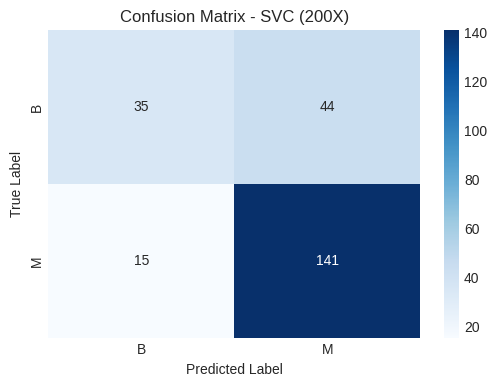

Confusion matrix plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/svc_200X_confusion_matrix.png

ROC AUC Score: 0.7739


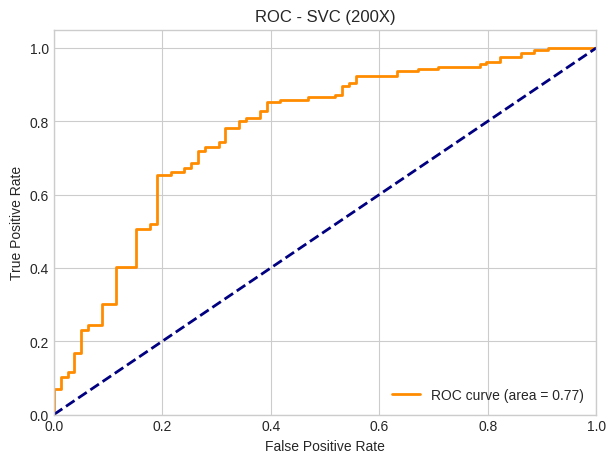

ROC curve plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/svc_200X_roc_curve.png

--- Evaluating XGBoost ---

--- Evaluation Metrics for: XGBoost on Test Set (200X) ---
Accuracy: 0.7021

Classification Report:

              precision    recall  f1-score   support

           B       0.61      0.32      0.42        79
           M       0.72      0.90      0.80       156

    accuracy                           0.70       235
   macro avg       0.67      0.61      0.61       235
weighted avg       0.68      0.70      0.67       235

Classification report saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/200X/xgboost_200X_classification_report.txt

Confusion Matrix:


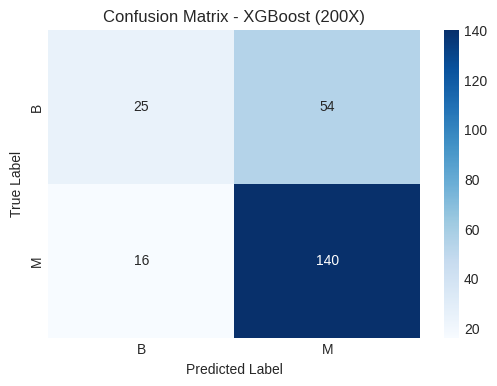

Confusion matrix plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/xgboost_200X_confusion_matrix.png

ROC AUC Score: 0.7361


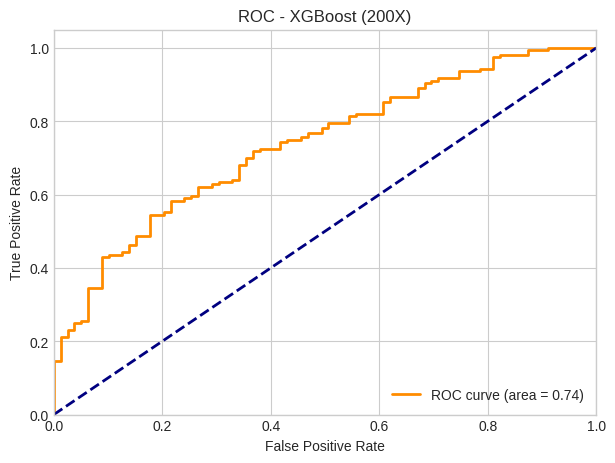

ROC curve plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/xgboost_200X_roc_curve.png

--- Evaluating RandomForest ---

--- Evaluation Metrics for: RandomForest on Test Set (200X) ---
Accuracy: 0.7021

Classification Report:

              precision    recall  f1-score   support

           B       0.70      0.20      0.31        79
           M       0.70      0.96      0.81       156

    accuracy                           0.70       235
   macro avg       0.70      0.58      0.56       235
weighted avg       0.70      0.70      0.64       235

Classification report saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/200X/randomforest_200X_classification_report.txt

Confusion Matrix:


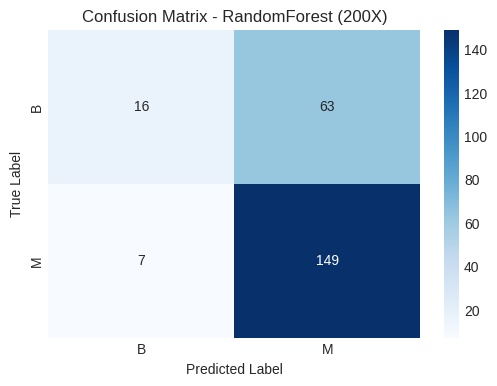

Confusion matrix plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/randomforest_200X_confusion_matrix.png

ROC AUC Score: 0.7891


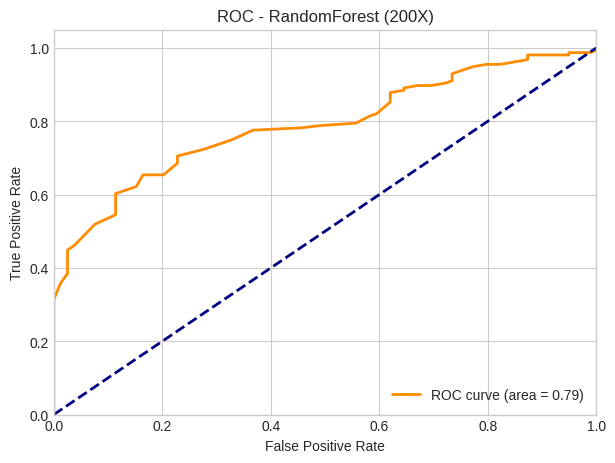

ROC curve plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/randomforest_200X_roc_curve.png

--- Evaluating MLP ---

--- Evaluation Metrics for: MLP on Test Set (200X) ---
Accuracy: 0.7191

Classification Report:

              precision    recall  f1-score   support

           B       0.68      0.32      0.43        79
           M       0.73      0.92      0.81       156

    accuracy                           0.72       235
   macro avg       0.70      0.62      0.62       235
weighted avg       0.71      0.72      0.68       235

Classification report saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/200X/mlp_200X_classification_report.txt

Confusion Matrix:


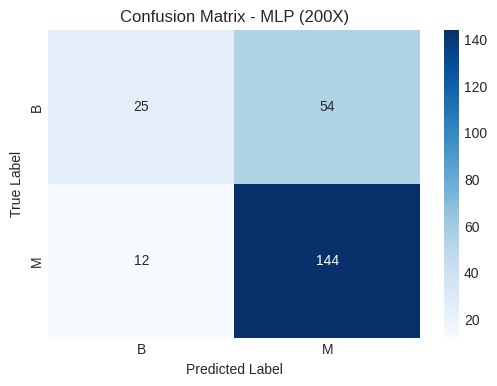

Confusion matrix plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/mlp_200X_confusion_matrix.png

ROC AUC Score: 0.7768


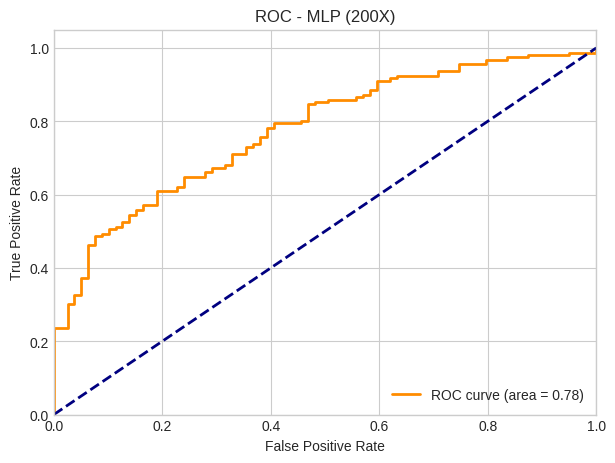

ROC curve plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/mlp_200X_roc_curve.png

--- Evaluating LogisticRegression ---

--- Evaluation Metrics for: LogisticRegression on Test Set (200X) ---
Accuracy: 0.7447

Classification Report:

              precision    recall  f1-score   support

           B       0.60      0.70      0.65        79
           M       0.83      0.77      0.80       156

    accuracy                           0.74       235
   macro avg       0.72      0.73      0.72       235
weighted avg       0.76      0.74      0.75       235

Classification report saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/200X/logisticregression_200X_classification_report.txt

Confusion Matrix:


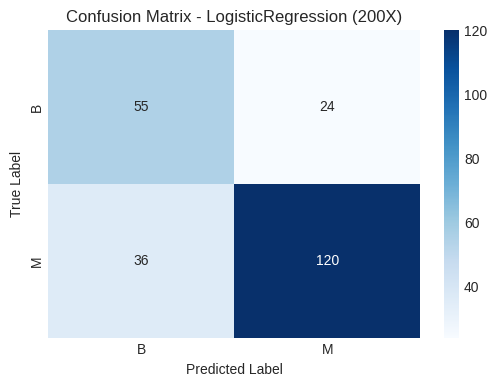

Confusion matrix plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/logisticregression_200X_confusion_matrix.png

ROC AUC Score: 0.8362


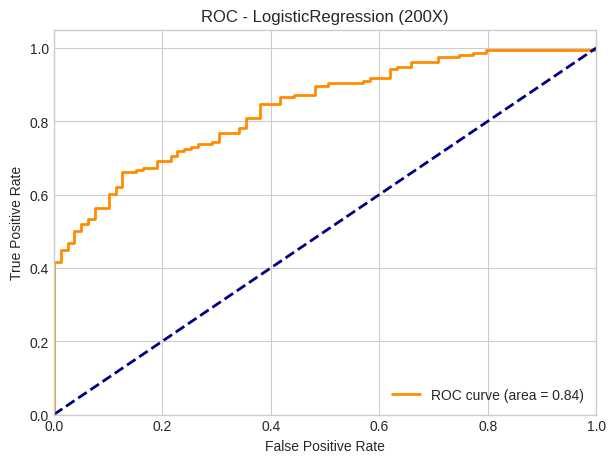

ROC curve plot saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/figures/200X/logisticregression_200X_roc_curve.png


In [35]:
print(f"\n\n=== Evaluating All Models on Test Set for {TARGET_MAGNIFICATION} ===")

if not X_test_scaled.empty and y_test.size > 0 and np.any(y_test != -1):
    for model_name, model_instance in models.items():
        if model_instance is not None:
            print(f"\n--- Evaluating {model_name} ---")
            acc, cm, roc = evaluate_model(model_name, model_instance, X_test_scaled, y_test, le, TARGET_MAGNIFICATION)
            model_accuracies[model_name] = acc
            model_cms[model_name] = cm
            model_roc_aucs[model_name] = roc
        else:
            print(f"\nSkipping evaluation for {model_name} as it was not trained successfully.")
            model_accuracies[model_name] = 0.0
            model_cms[model_name] = None
            model_roc_aucs[model_name] = None
elif X_test_scaled.empty or y_test.size == 0 or np.all(y_test == -1):
    print("\nSkipping all model evaluations: Test data or labels are empty or invalid.")
else:
    print("\nSkipping all model evaluations: Training data was not processed, so no models were trained.")

## 11. Conclusion & Summary (for this Magnification Run)


In [36]:
print(f"\n\n--- Final Summary for {TARGET_MAGNIFICATION} Magnification ---")
if not df_all_images.empty:
    print(f"Processed {len(all_image_paths_info)} {TARGET_MAGNIFICATION} images from {df_all_images['patient_slide_id'].nunique()} unique patient/slides.")
    if train_image_info_list:
        print(f"Used {len(train_image_info_list)} images for training (from {len(set(item['patient_slide_id'] for item in train_image_info_list))} patients/slides).")
    if test_image_info_list:
        print(f"Used {len(test_image_info_list)} images for testing (from {len(set(item['patient_slide_id'] for item in test_image_info_list))} patients/slides).")
print("\n")
if not X_train_scaled.empty:
    print(f"Training data samples after cleaning: {X_train_scaled.shape[0]}")
else:
    print("Training data: N/A or empty after cleaning.")
if not X_test_scaled.empty:
    print(f"Testing data samples after cleaning: {X_test_scaled.shape[0]}")
else:
    print("Testing data: N/A or empty after cleaning.")

print(f"\n--- Model Performance on Test Set ({TARGET_MAGNIFICATION}) ---")
if model_accuracies:
    # Create a DataFrame for easier comparison
    performance_data = []
    for model_name in models.keys():
        if model_name in model_accuracies:
            acc = model_accuracies.get(model_name, float('nan'))
            roc = model_roc_aucs.get(model_name, float('nan'))
            performance_data.append({'Model': model_name, 'Accuracy': acc, 'ROC AUC': roc})
        else:
            performance_data.append({'Model': model_name, 'Accuracy': 'N/A', 'ROC AUC': 'N/A'})
    
    df_performance = pd.DataFrame(performance_data)
    print(df_performance.to_string(index=False))
    
    print("\nReview detailed metrics (precision, recall, F1, Confusion Matrix) for each model in the plots/text outputs above and saved files.")
    # Save overall performance summary
    summary_report_path = PROJ_ROOT_DIR / 'reports' / f"model_performance_summary_{TARGET_MAGNIFICATION}.csv"
    df_performance.to_csv(summary_report_path, index=False)
    print(f"Overall model performance summary saved to {summary_report_path}")
else:
    print("No models were successfully trained or evaluated for this magnification.")

print("\n\nConsiderations & Next Steps (Specific to this Magnification run):")
print(f"- Analyze the {TARGET_MAGNIFICATION} specific results. Are there particular challenges or strengths at this zoom level?")
print("- Ensure the `contour_filters_by_magnification` for {TARGET_MAGNIFICATION} in `segmentation_config.json` are optimal.")
print("- If this is the final magnification run, proceed to combine insights or prepare for multi-magnification feature fusion.")




--- Final Summary for 200X Magnification ---
Processed 2013 200X images from 82 unique patient/slides.
Used 1778 images for training (from 73 patients/slides).
Used 235 images for testing (from 9 patients/slides).


Training data samples after cleaning: 1778
Testing data samples after cleaning: 235

--- Model Performance on Test Set (200X) ---
             Model  Accuracy  ROC AUC
               SVC  0.748936 0.773937
           XGBoost  0.702128 0.736125
      RandomForest  0.702128 0.789070
               MLP  0.719149 0.776777
LogisticRegression  0.744681 0.836173

Review detailed metrics (precision, recall, F1, Confusion Matrix) for each model in the plots/text outputs above and saved files.
Overall model performance summary saved to /home/sih/Documents/GI/l4_s2/decisional_informatics/projects/breast-cancer/reports/model_performance_summary_200X.csv


Considerations & Next Steps (Specific to this Magnification run):
- Analyze the 200X specific results. Are there particular challe